# Zero-shot Segmenation Results Quantification

## Setup

In [1]:
# imports
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    jaccard_score,
)


In [2]:
# config
DATA_ROOT = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
PRED_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot/results"

DATASETS = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["image_clip", "image_only", "random", "threshold"]

MODEL_TITLES = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
    "threshold": "Threshold",
}



In [3]:
# utils

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

def dice_numpy(pred, gt, eps=1e-8):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2 * inter) / (pred.sum() + gt.sum() + eps)


In [4]:
# metric computation
rows = []

for dataset in DATASETS:
    print(f"\nProcessing dataset: {dataset}")
    gt_dir   = os.path.join(DATA_ROOT, dataset)
    pred_dir = os.path.join(PRED_ROOT, dataset)

    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*_label.nii.gz")))

    for gt_path in gt_files:
        base = os.path.basename(gt_path).replace("_label.nii.gz", "")
        gt = load_nifti(gt_path).astype(bool)

        for model in MODELS:
            pred_path = os.path.join(pred_dir, f"{base}_pred_{model}.nii.gz")
            prob_path = os.path.join(pred_dir, f"{base}_prob_{model}.nii.gz")

            if not (os.path.exists(pred_path) and os.path.exists(prob_path)):
                continue

            pred = load_nifti(pred_path).astype(bool)
            prob = load_nifti(prob_path)

            gt_flat   = gt.flatten()
            pred_flat = pred.flatten()
            prob_flat = prob.flatten()

            # Binary metrics
            dice = dice_numpy(pred, gt)
            iou  = jaccard_score(gt_flat, pred_flat)
            prec = precision_score(gt_flat, pred_flat, zero_division=0)
            rec  = recall_score(gt_flat, pred_flat, zero_division=0)

            # Threshold-free metrics
            try:
                roc = roc_auc_score(gt_flat, prob_flat)
            except ValueError:
                roc = np.nan

            try:
                pr = average_precision_score(gt_flat, prob_flat)
            except ValueError:
                pr = np.nan

            rows.append({
                "dataset": dataset,
                "patch": base,
                "model": model,
                "dice": dice,
                "iou": iou,
                "precision": prec,
                "recall": rec,
                "roc_auc": roc,
                "pr_auc": pr,
            })
            


Processing dataset: amyloid_plaque_patches

Processing dataset: c_fos_positive_patches

Processing dataset: cell_nucleus_patches

Processing dataset: vessels_patches


## Summary stats and plots

dataset       model      dice                 iou  \
                                            mean       std      mean   
0   amyloid_plaque_patches  image_clip  0.018667  0.038115  0.009800   
1   amyloid_plaque_patches  image_only  0.018854  0.039030  0.009915   
2   amyloid_plaque_patches      random  0.017752  0.034410  0.009262   
3   amyloid_plaque_patches   threshold  0.068143  0.084476  0.037289   
4   c_fos_positive_patches  image_clip  0.136933  0.044142  0.073950   
5   c_fos_positive_patches  image_only  0.122891  0.039003  0.065812   
6   c_fos_positive_patches      random  0.063648  0.076746  0.034108   
7   c_fos_positive_patches   threshold  0.474745  0.036332  0.311810   
8     cell_nucleus_patches  image_clip  0.430934  0.097806  0.279513   
9     cell_nucleus_patches  image_only  0.429210  0.080089  0.276512   
10    cell_nucleus_patches      random  0.459700  0.097897  0.303607   
11    cell_nucleus_patches   threshold  0.468282  0.115679  0.312929   
12         vessels_patches  image_clip  0.299590  0.153541  0.186285   
13         vessels_patches  image_only  0.307377  0.149741  0.190764   
14         vessels_patches      random  0.296204  0.141392  0.182159   
15         vessels_patches   threshold  0.113980  0.032325  0.060735   

             precision              recall             roc_auc            \
         std      mean       std      mean       std      mean       std   
0   0.020773  0.009863  0.020991  0.662506  0.384107  0.850708  0.155043   
1   0.021372  0.010024  0.021779  0.713693  0.318880  0.894496  0.091564   
2   0.018637  0.009337  0.018895  0.733145  0.320081  0.893188  0.090611   
3   0.048729  0.040362  0.054421  0.410301  0.344071  0.916343  0.086841   
4   0.025405  0.075620  0.026725  0.802688  0.038247  0.903003  0.017072   
5   0.022030  0.068872  0.024357  0.697627  0.167984  0.864218  0.026109   
6   0.041640  0.042977  0.057420  0.288946  0.407143  0.667974  0.271666   
7   0.030963  0.751941  0.161957  0.369604  0.102032  0.944408  0.009241   
8   0.081519  0.295336  0.089264  0.862894  0.104290  0.972636  0.019526   
9   0.066888  0.293594  0.075286  0.856235  0.111359  0.971104  0.019746   
10  0.084727  0.320383  0.090730  0.864524  0.080221  0.975141  0.017044   
11  0.099809  0.798368  0.122362  0.341991  0.113370  0.986248  0.011155   
12  0.115396  0.735143  0.301030  0.208422  0.123605  0.901305  0.053316   
13  0.106736  0.713495  0.297304  0.225233  0.137180  0.898993  0.051788   
14  0.103306  0.697708  0.324133  0.217467  0.123609  0.896246  0.055623   
15  0.018022  0.939473  0.168850  0.060913  0.018020  0.929203  0.048913   

      pr_auc            
        mean       std  
0   0.022983  0.060304  
1   0.039681  0.088433  
2   0.033607  0.073259  
3   0.291697  0.267552  
4   0.244843  0.068475  
5   0.137054  0.116599  
6   0.066317  0.058307  
7   0.551713  0.013798  
8   0.534864  0.145163  
9   0.517223  0.142370  
10  0.554722  0.138526  
11  0.697426  0.132459  
12  0.530220  0.209440  
13  0.524160  0.189883  
14  0.510183  0.213902  
15  0.648317  0.190939


=== Mean Dice by dataset ===

amyloid_plaque_patches
  image_clip  : 0.019 ± 0.038
  image_only  : 0.019 ± 0.039
  random      : 0.018 ± 0.034
  threshold   : 0.068 ± 0.084

c_fos_positive_patches
  image_clip  : 0.137 ± 0.044
  image_only  : 0.123 ± 0.039
  random      : 0.064 ± 0.077
  threshold   : 0.475 ± 0.036

cell_nucleus_patches
  image_clip  : 0.431 ± 0.098
  image_only  : 0.429 ± 0.080
  random      : 0.460 ± 0.098
  threshold   : 0.468 ± 0.116

vessels_patches
  image_clip  : 0.300 ± 0.154
  image_only  : 0.307 ± 0.150
  random      : 0.296 ± 0.141
  threshold   : 0.114 ± 0.032


<Figure size 1000x3000 with 0 Axes>

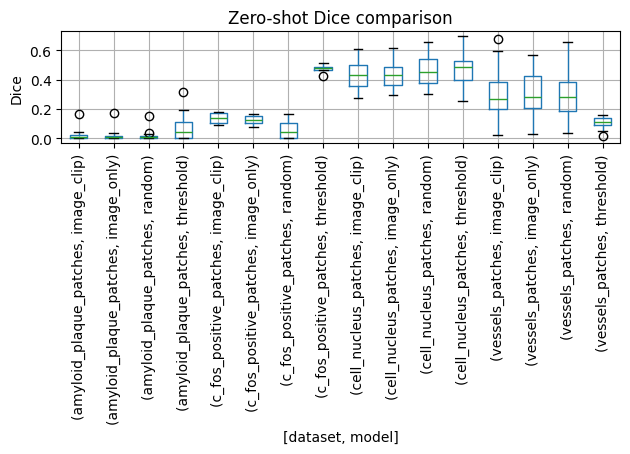

In [5]:
# create results dataframe
df = pd.DataFrame(rows)

# aggregate summary
metric_cols = [
    "dice",
    "iou",
    "precision",
    "recall",
    "roc_auc",
    "pr_auc",
]

summary = (
    df
    .groupby(["dataset", "model"])[metric_cols]
    .agg(["mean", "std"])
    .reset_index()
)

display(summary)

# print mean dice by dataset
print("\n=== Mean Dice by dataset ===")
for dataset in DATASETS:
    print(f"\n{dataset}")
    sub = df[df["dataset"] == dataset]
    for model in MODELS:
        m = sub[sub["model"] == model]["dice"]
        print(f"  {model:12s}: {m.mean():.3f} ± {m.std():.3f}")

# boxplot visualization
plt.figure(figsize=(10,30))
df.boxplot(column="dice", by=["dataset", "model"], rot=90)
plt.title("Zero-shot Dice comparison")
plt.suptitle("")
plt.ylabel("Dice")
plt.tight_layout()
plt.show()


### Boxplots

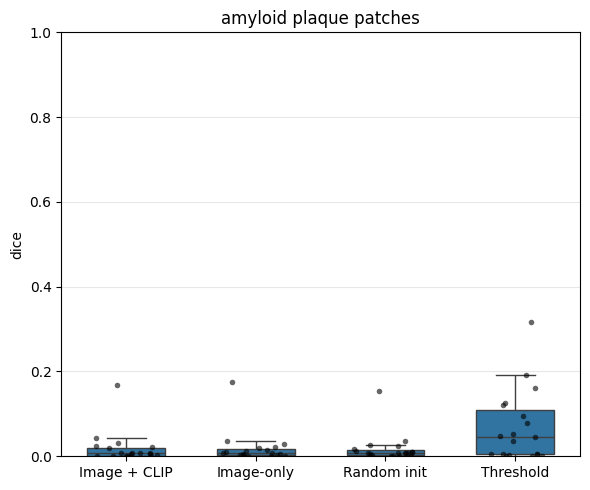

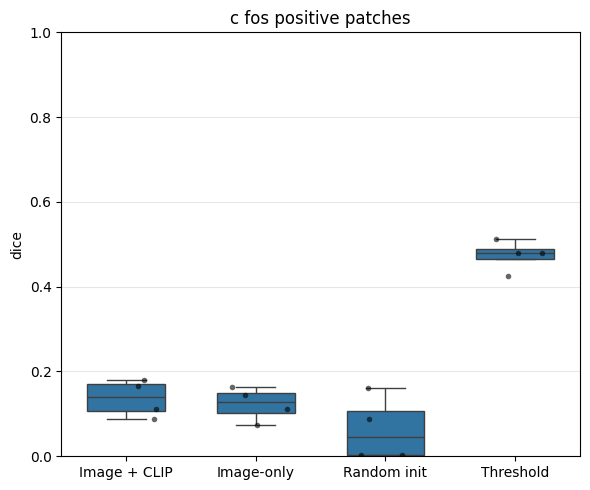

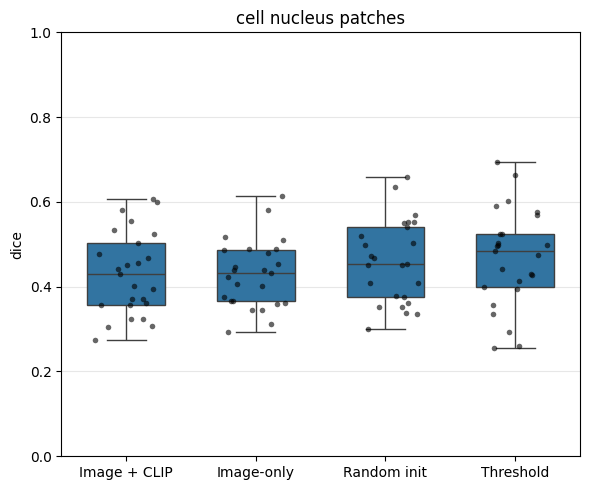

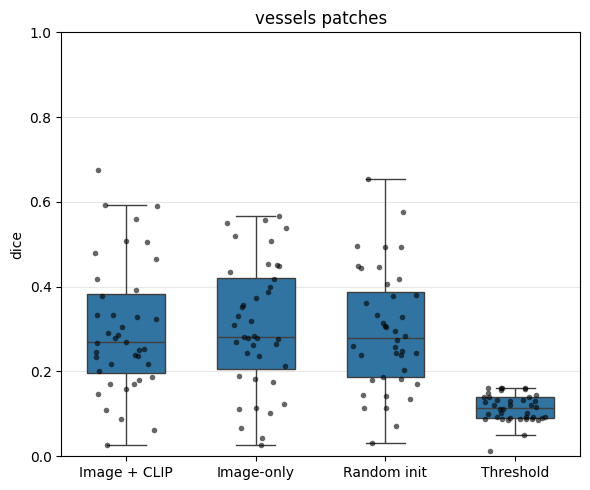

In [10]:
# Consistent ordering across plots
MODEL_ORDER = ["image_clip", "image_only", "random", "threshold"]

# Optional: nicer model labels
MODEL_LABELS = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
    "threshold": "Threshold",
}

def boxplot_with_points_per_dataset(df, metric="dice", save_dir=None):
    datasets = sorted(df["dataset"].unique())

    for dataset in datasets:
        sub = df[df["dataset"] == dataset].copy()

        plt.figure(figsize=(6, 5))

        # Boxplot
        sns.boxplot(
            data=sub,
            x="model",
            y=metric,
            order=MODEL_ORDER,
            showfliers=False,
            width=0.6,
        )

        # Overlay individual points
        sns.stripplot(
            data=sub,
            x="model",
            y=metric,
            order=MODEL_ORDER,
            color="black",
            alpha=0.6,
            jitter=0.25,
            size=4,
        )

        # Labels and formatting
        plt.title(f"{dataset.replace('_', ' ')}")
        plt.xlabel("")
        plt.ylabel(metric)
        plt.ylim(0, 1)
        plt.grid(axis="y", alpha=0.3)

        # Replace x-axis labels with nicer names
        plt.xticks(
            ticks=range(len(MODEL_ORDER)),
            labels=[MODEL_LABELS[m] for m in MODEL_ORDER],
        )

        plt.tight_layout()

        # Optional save
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            out_path = os.path.join(
                save_dir, f"{dataset}_{metric}_boxplot.png"
            )
            plt.savefig(out_path, dpi=300)
            print(f"Saved: {out_path}")

        plt.show()


# ---------
# Run it
# ---------
boxplot_with_points_per_dataset(df, metric="dice")


## Visualize examples

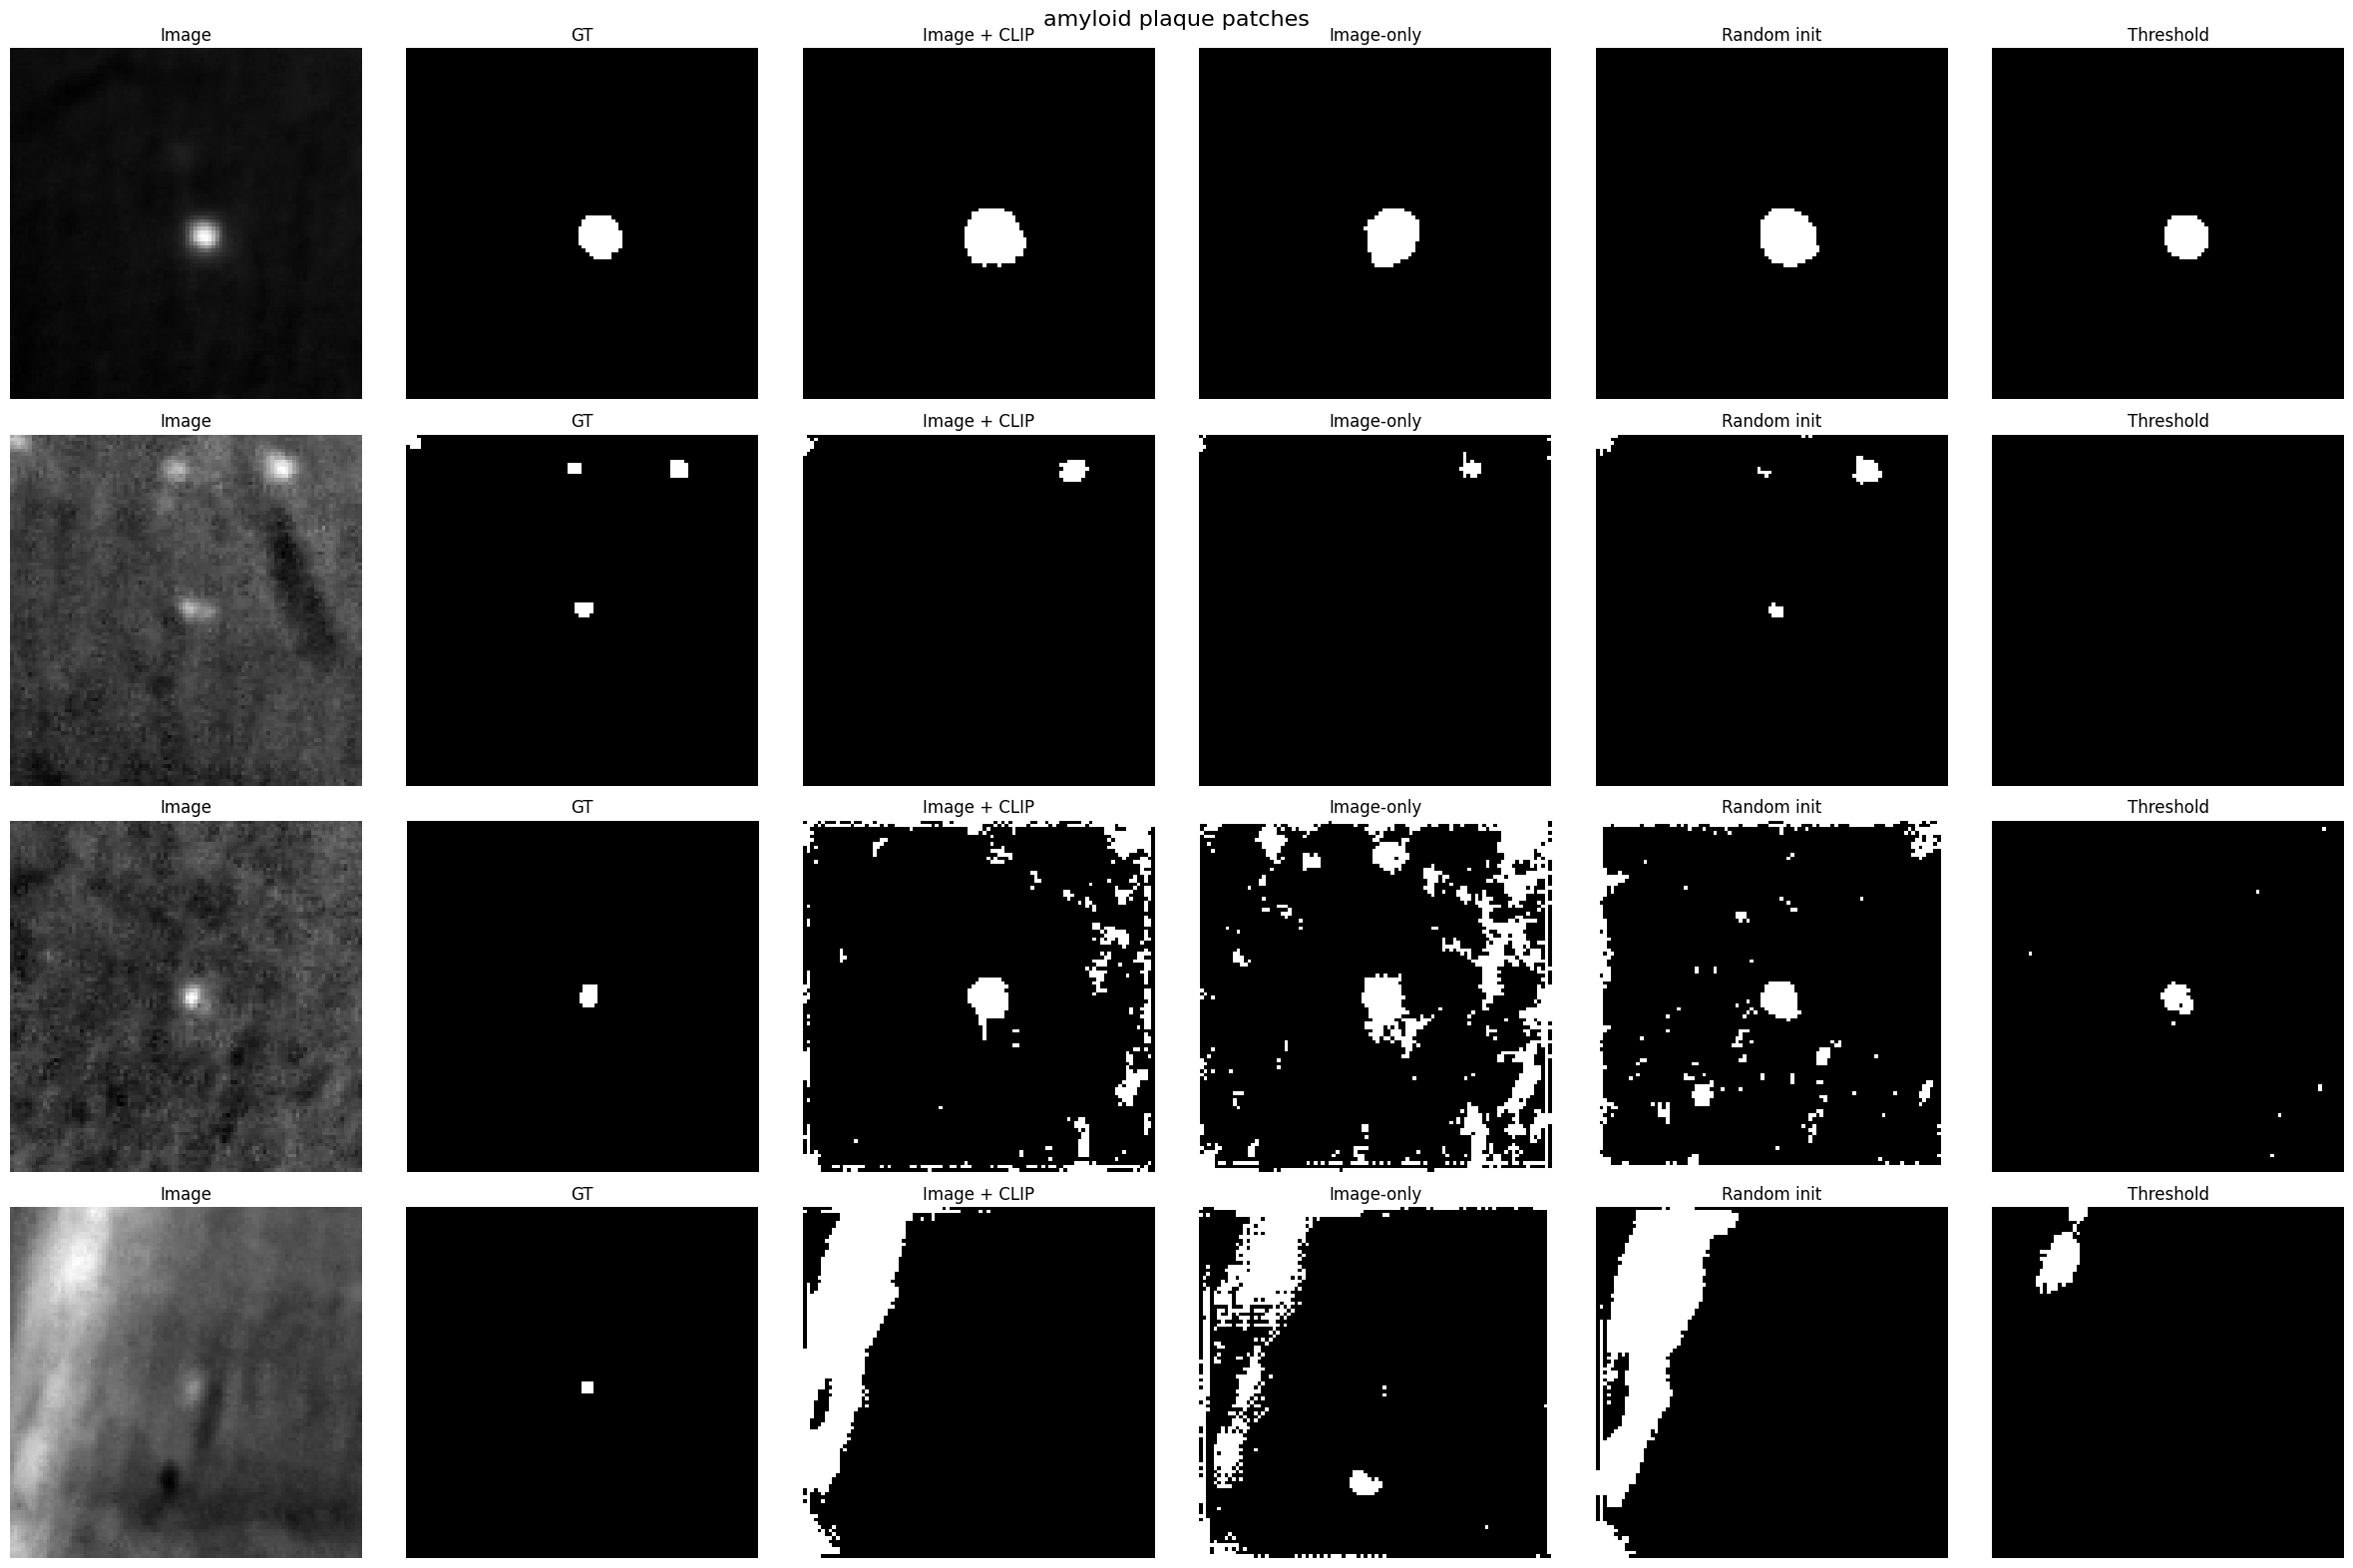

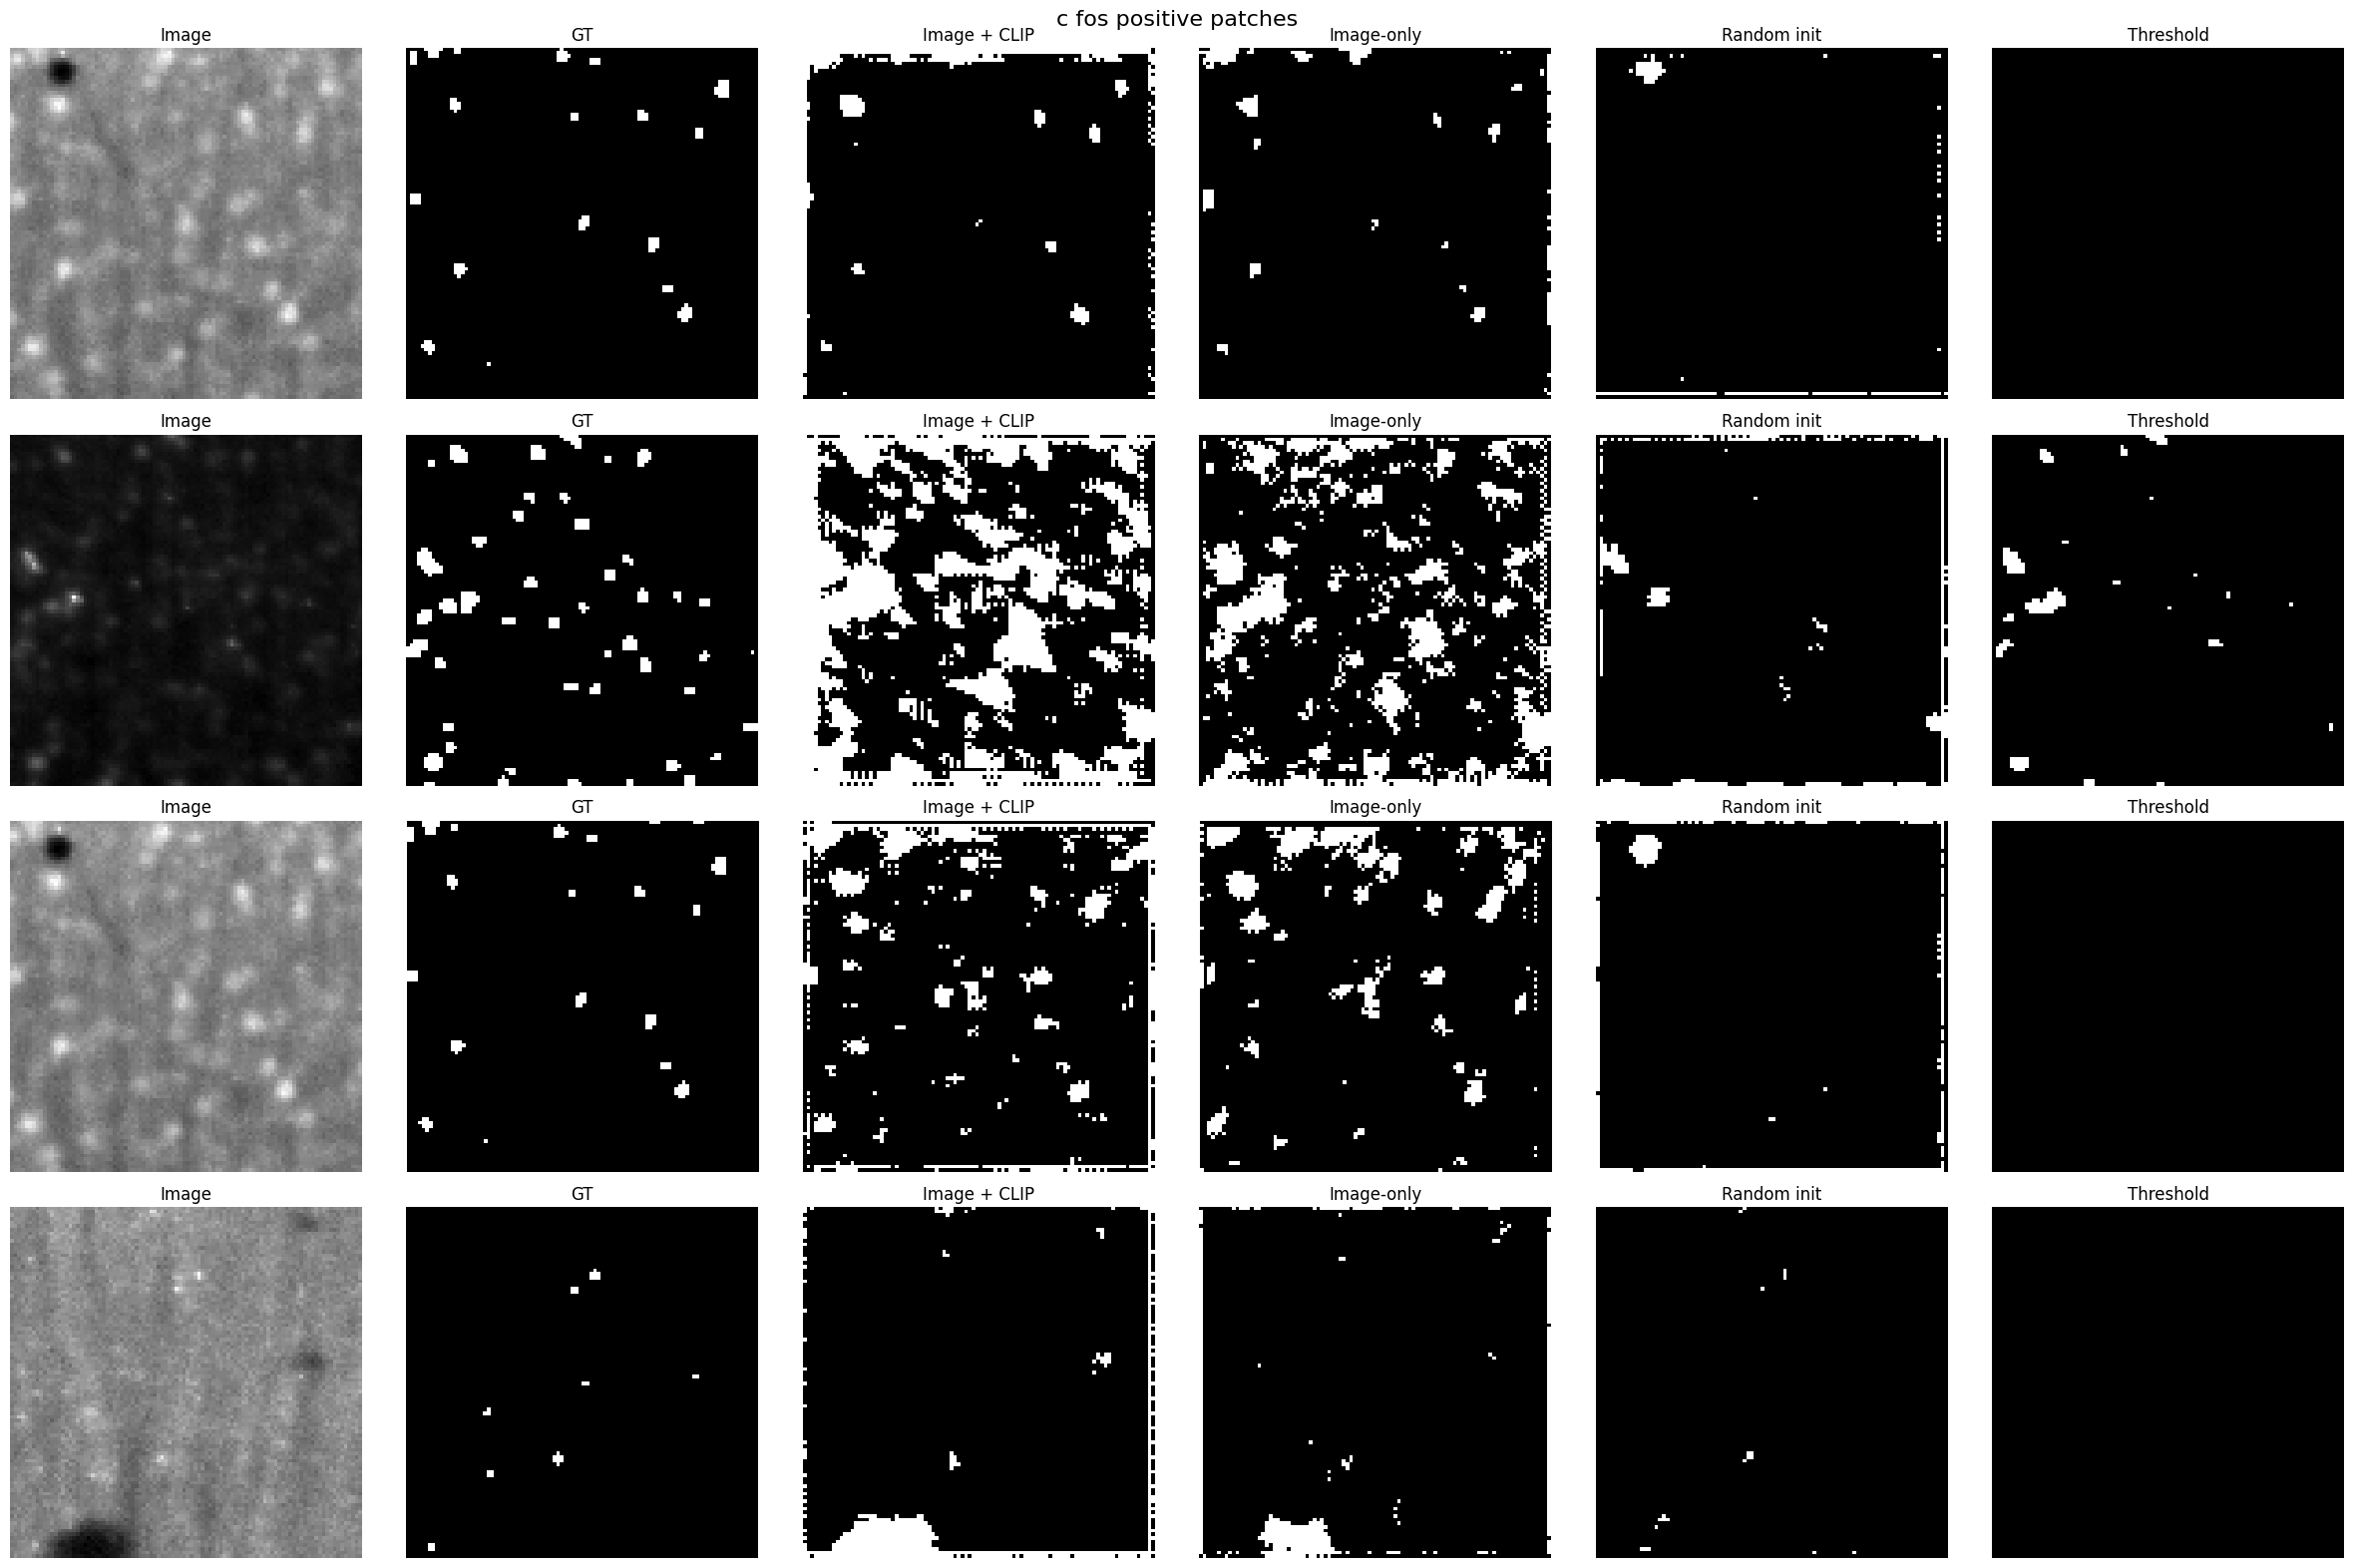

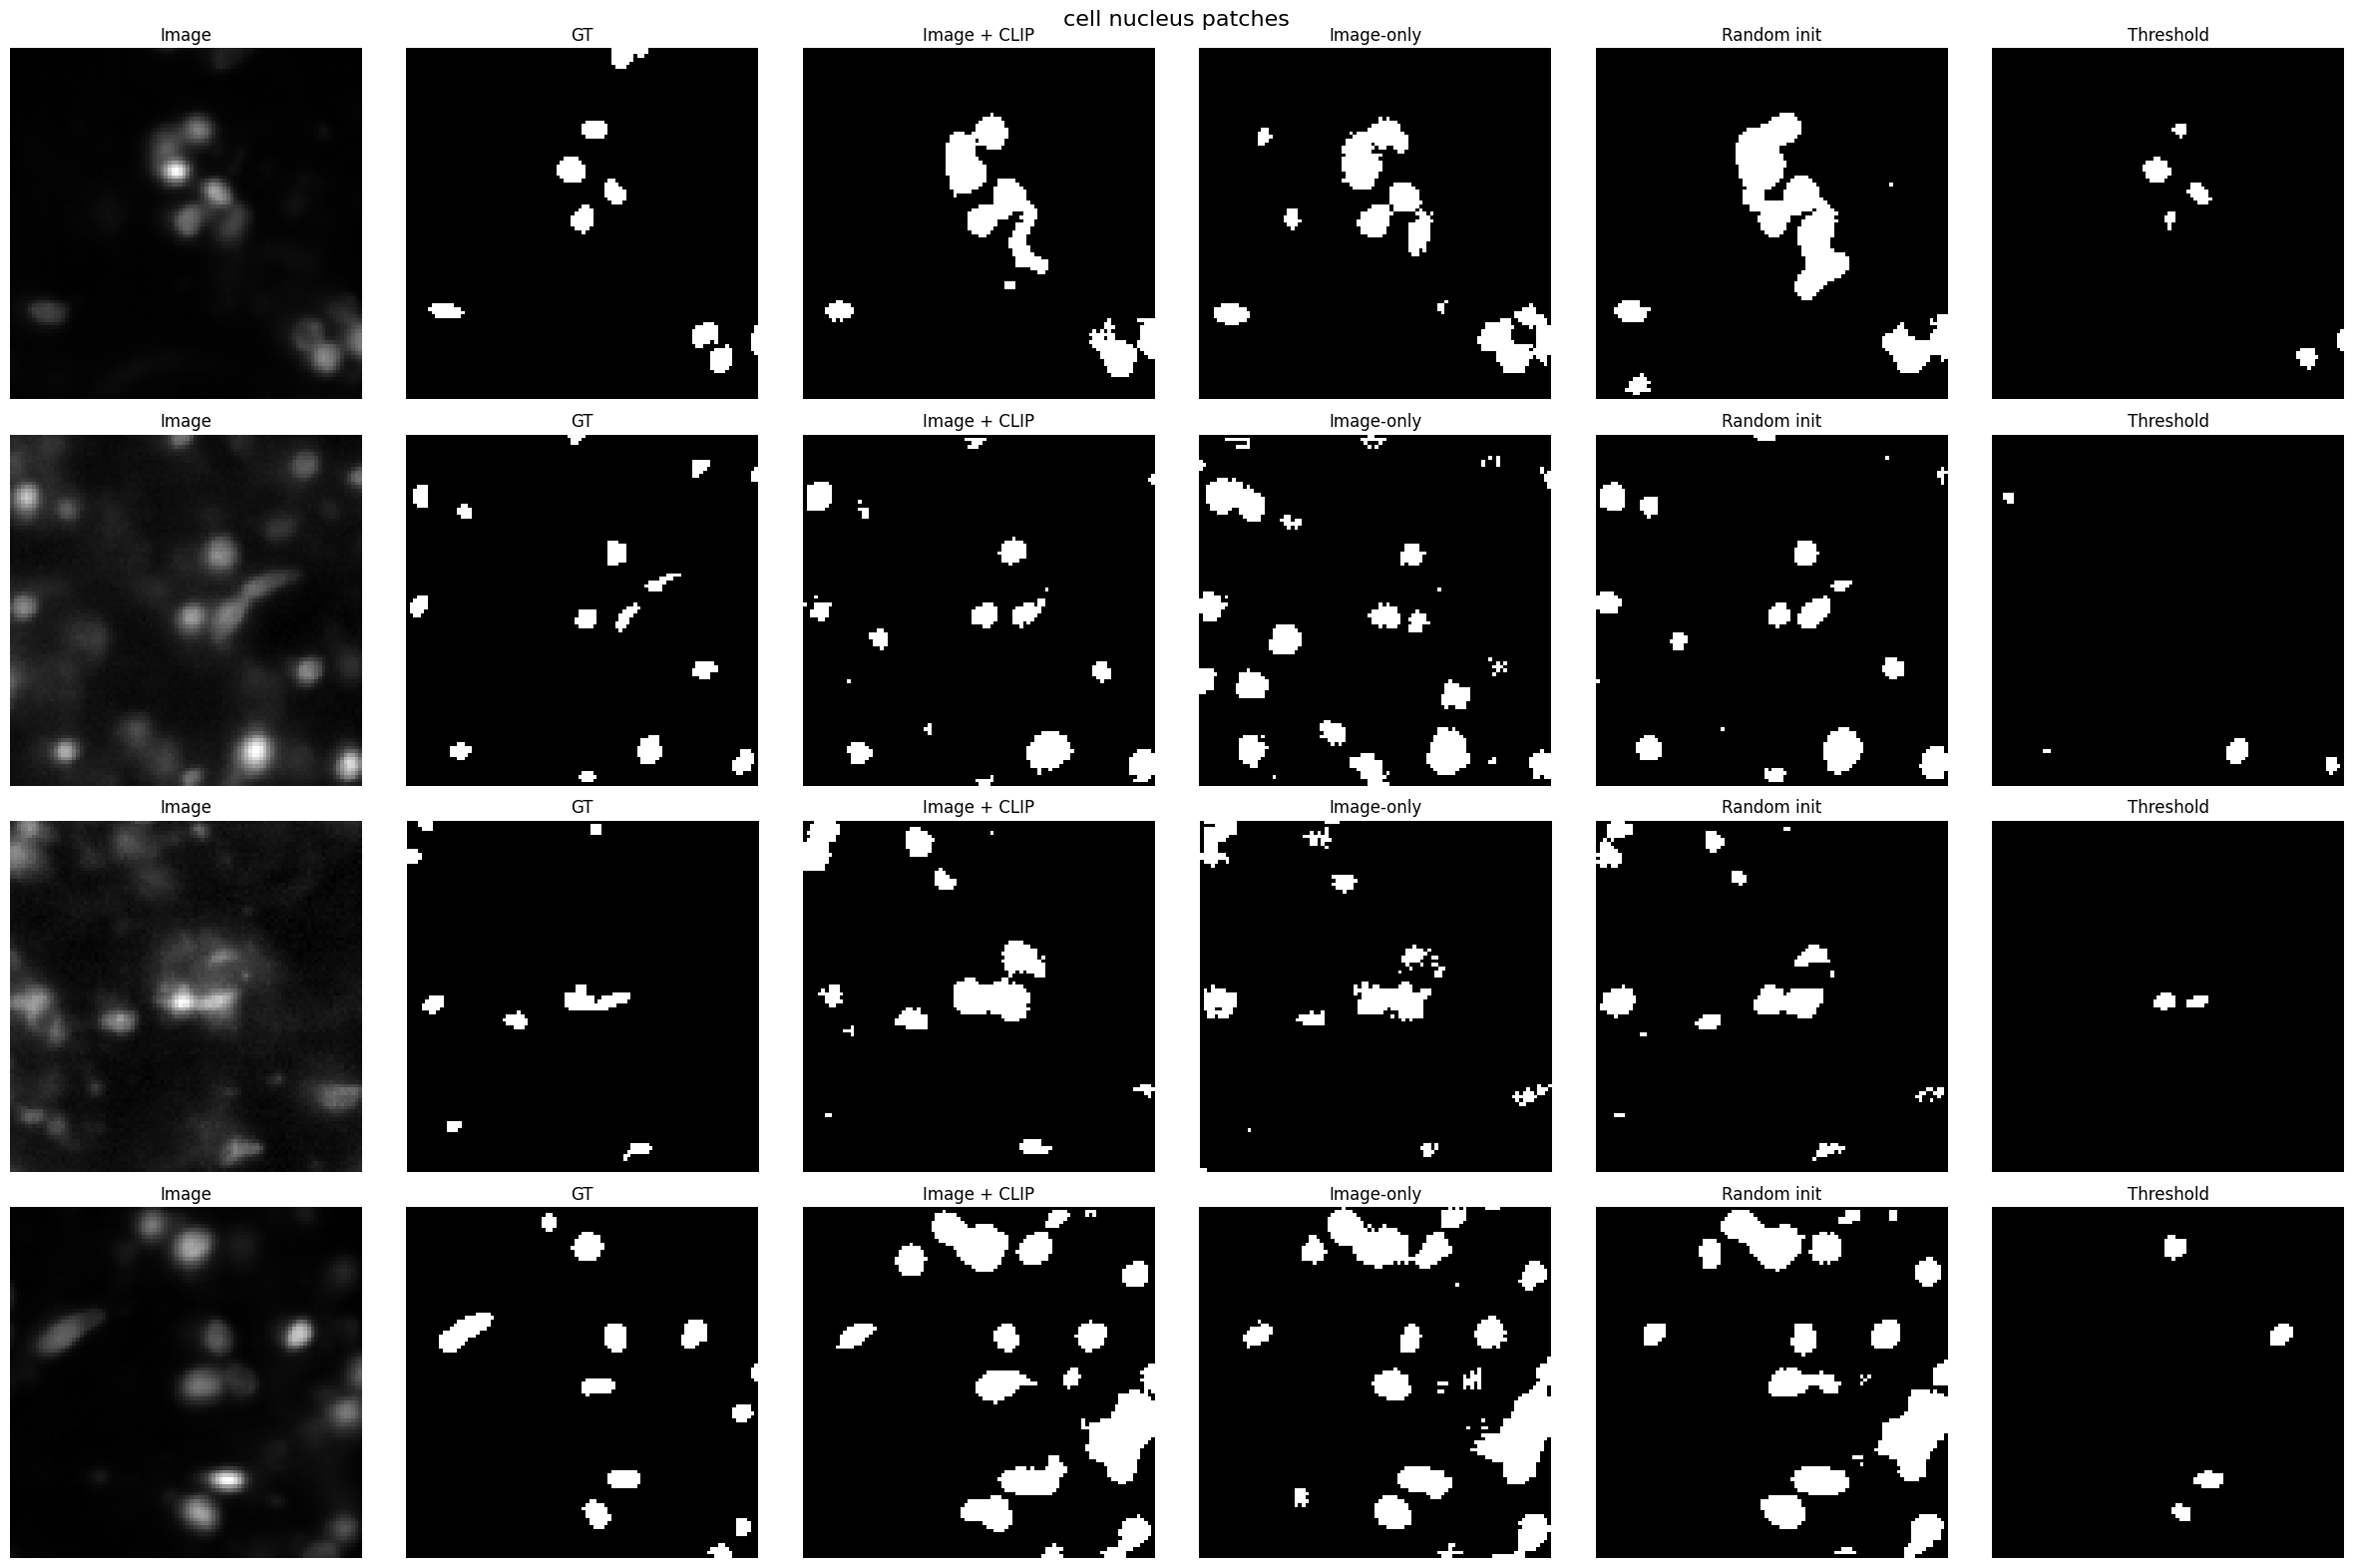

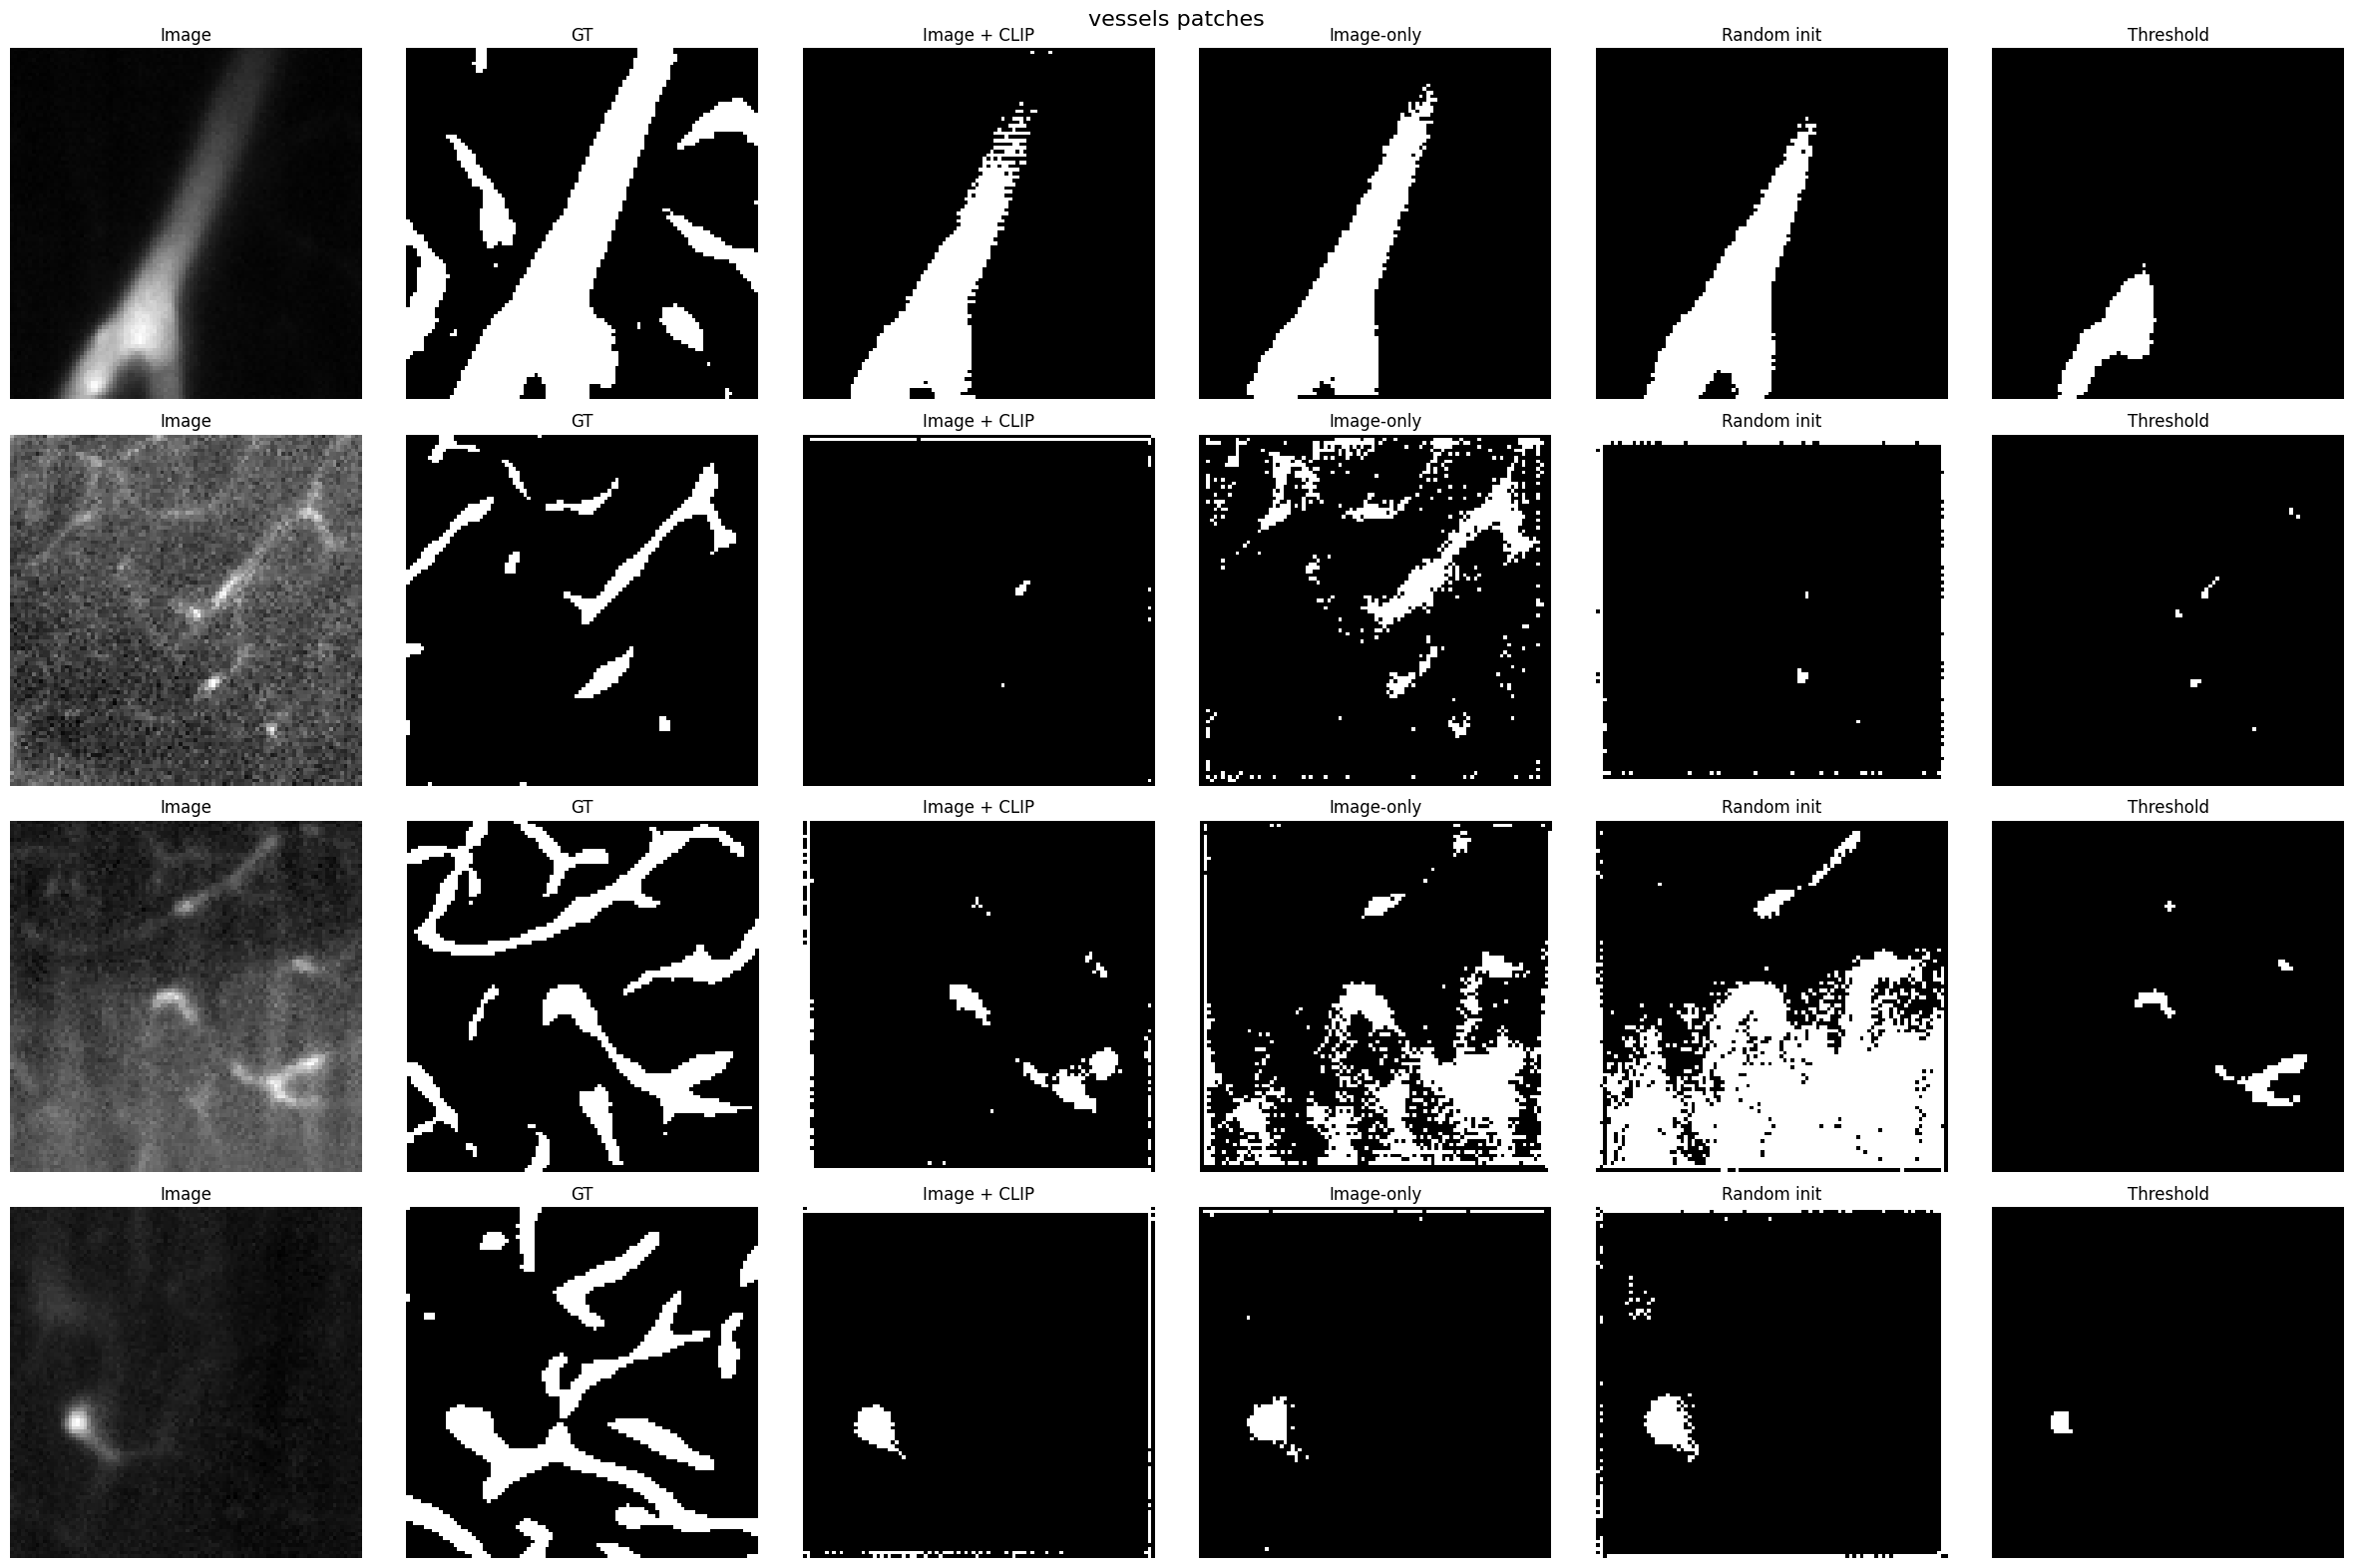

In [7]:
# visualize random examples

def show_random_examples(dataset, n_examples=4, seed=0):
    random.seed(seed)

    img_dir  = os.path.join(DATA_ROOT, dataset)
    pred_dir = os.path.join(PRED_ROOT, dataset)

    img_files = sorted(
        f for f in glob.glob(os.path.join(img_dir, "*.nii.gz"))
        if not f.endswith("_label.nii.gz")
    )

    chosen = random.sample(img_files, min(n_examples, len(img_files)))

    n_cols = 2 + len(MODELS)  # image + GT + preds
    fig, axes = plt.subplots(
        nrows=len(chosen),
        ncols=n_cols,
        figsize=(4*n_cols, 4*len(chosen))
    )

    if len(chosen) == 1:
        axes = axes[None, :]  # keep 2D indexing

    for row, img_path in enumerate(chosen):
        base = os.path.basename(img_path).replace(".nii.gz", "")

        img = normalize(load_nifti(img_path))
        gt  = load_nifti(os.path.join(img_dir, f"{base}_label.nii.gz"))

        z = img.shape[-1] // 2

        # ---- Image ----
        axes[row, 0].imshow(img[:, :, z], cmap="gray")
        axes[row, 0].set_title("Image")

        # ---- Ground truth ----
        axes[row, 1].imshow(gt[:, :, z], cmap="gray")
        axes[row, 1].set_title("GT")

        # ---- Predictions ----
        for col, model in enumerate(MODELS):
            pred_path = os.path.join(
                pred_dir, f"{base}_pred_{model}.nii.gz"
            )

            if os.path.exists(pred_path):
                pred = load_nifti(pred_path)
                axes[row, 2+col].imshow(pred[:, :, z], cmap="gray")
            else:
                axes[row, 2+col].text(
                    0.5, 0.5, "MISSING",
                    ha="center", va="center"
                )

            axes[row, 2+col].set_title(MODEL_TITLES[model])

        for a in axes[row]:
            a.axis("off")

    plt.suptitle(dataset.replace("_", " "), fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run for all datasets
# -----------------------------
for dataset in DATASETS:
    show_random_examples(dataset, n_examples=4, seed=100)


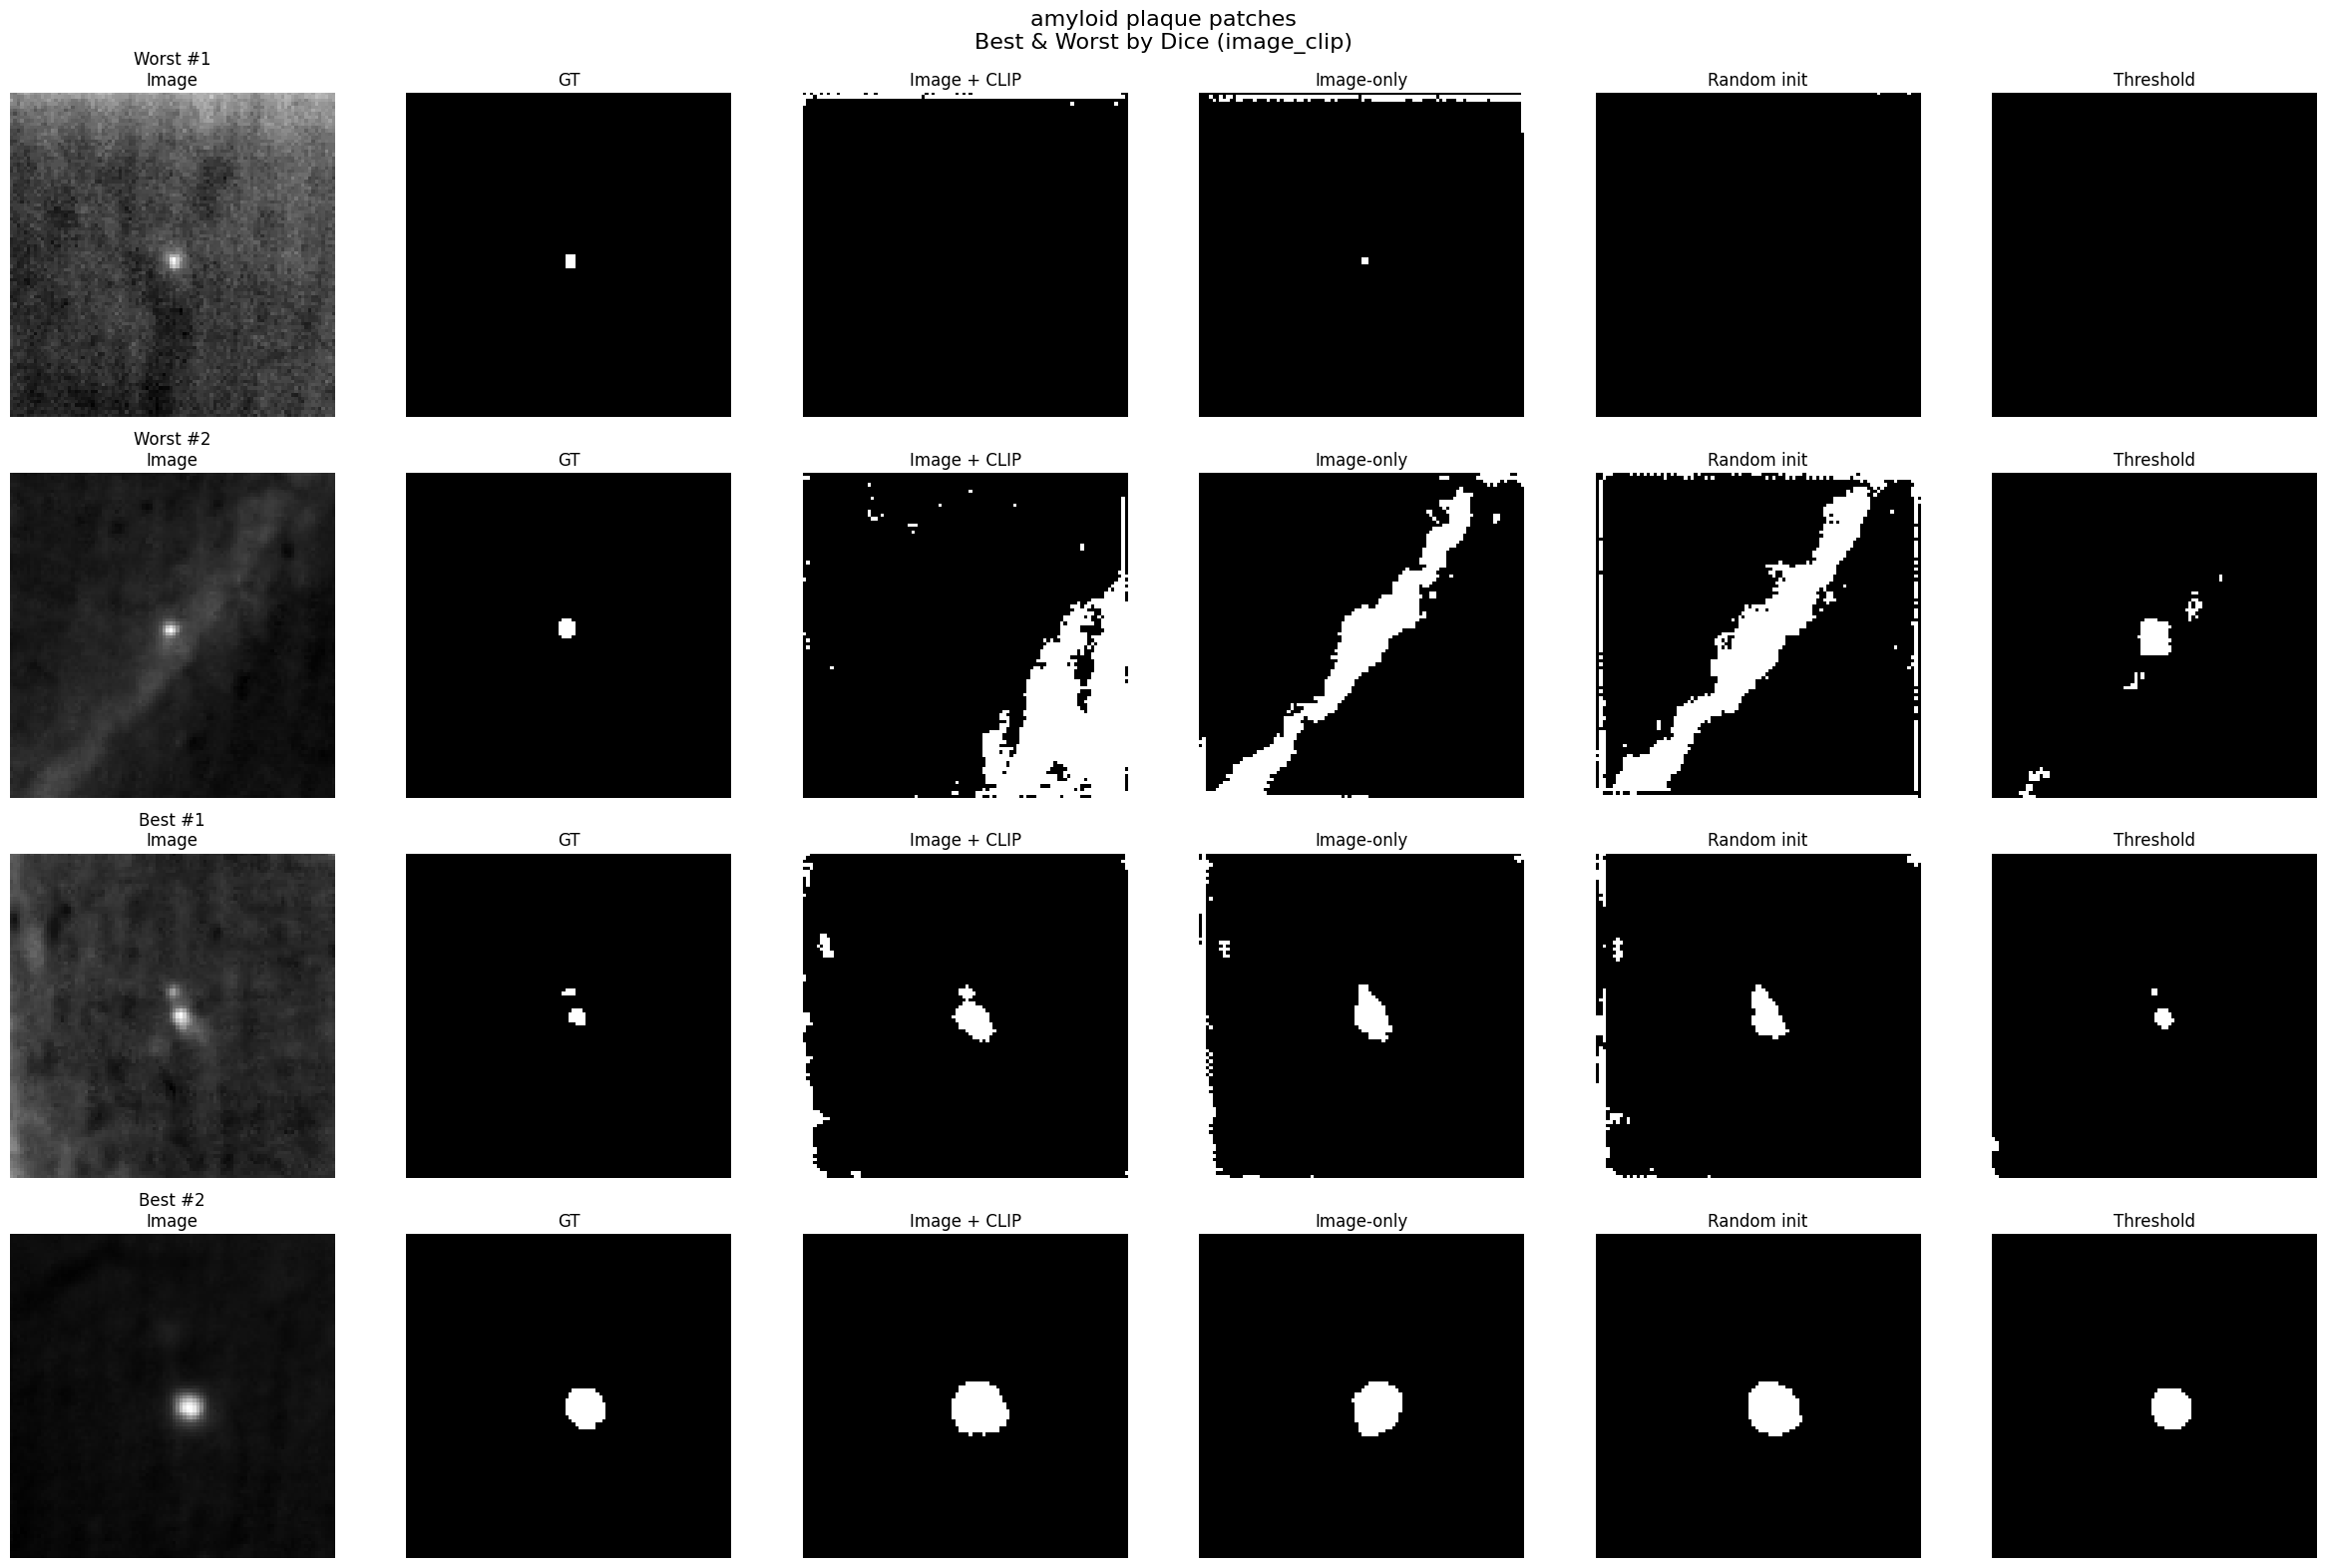

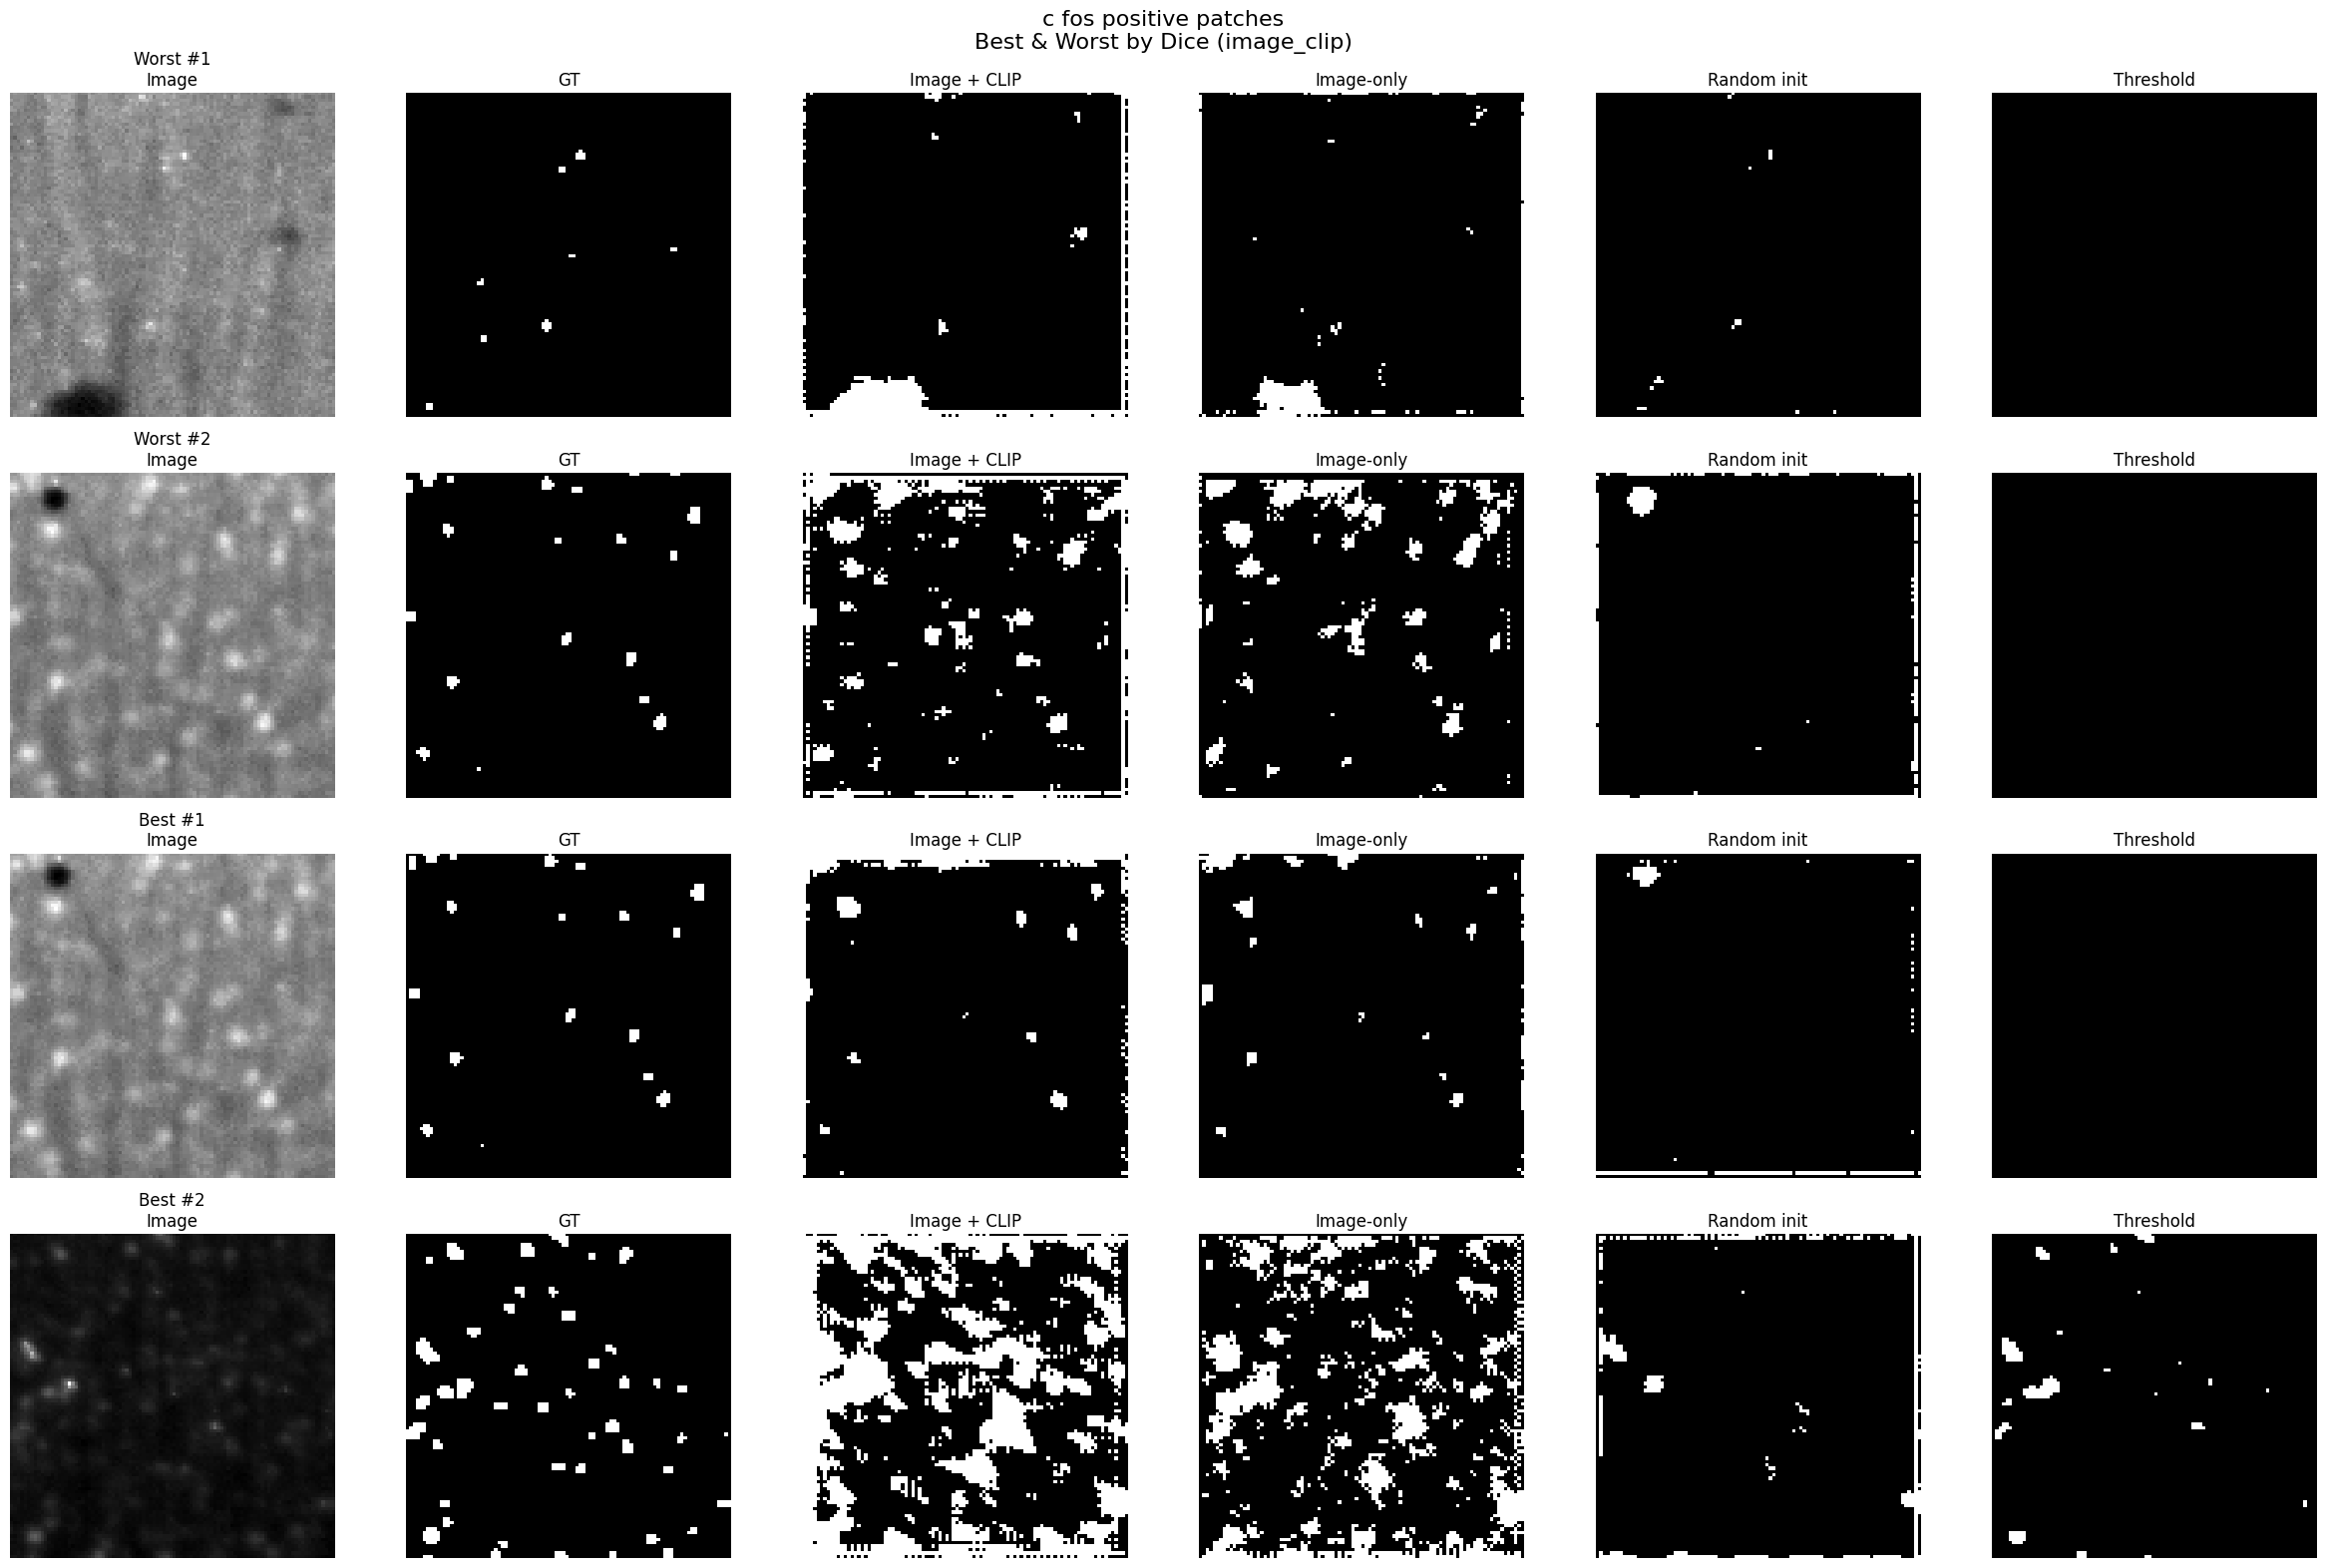

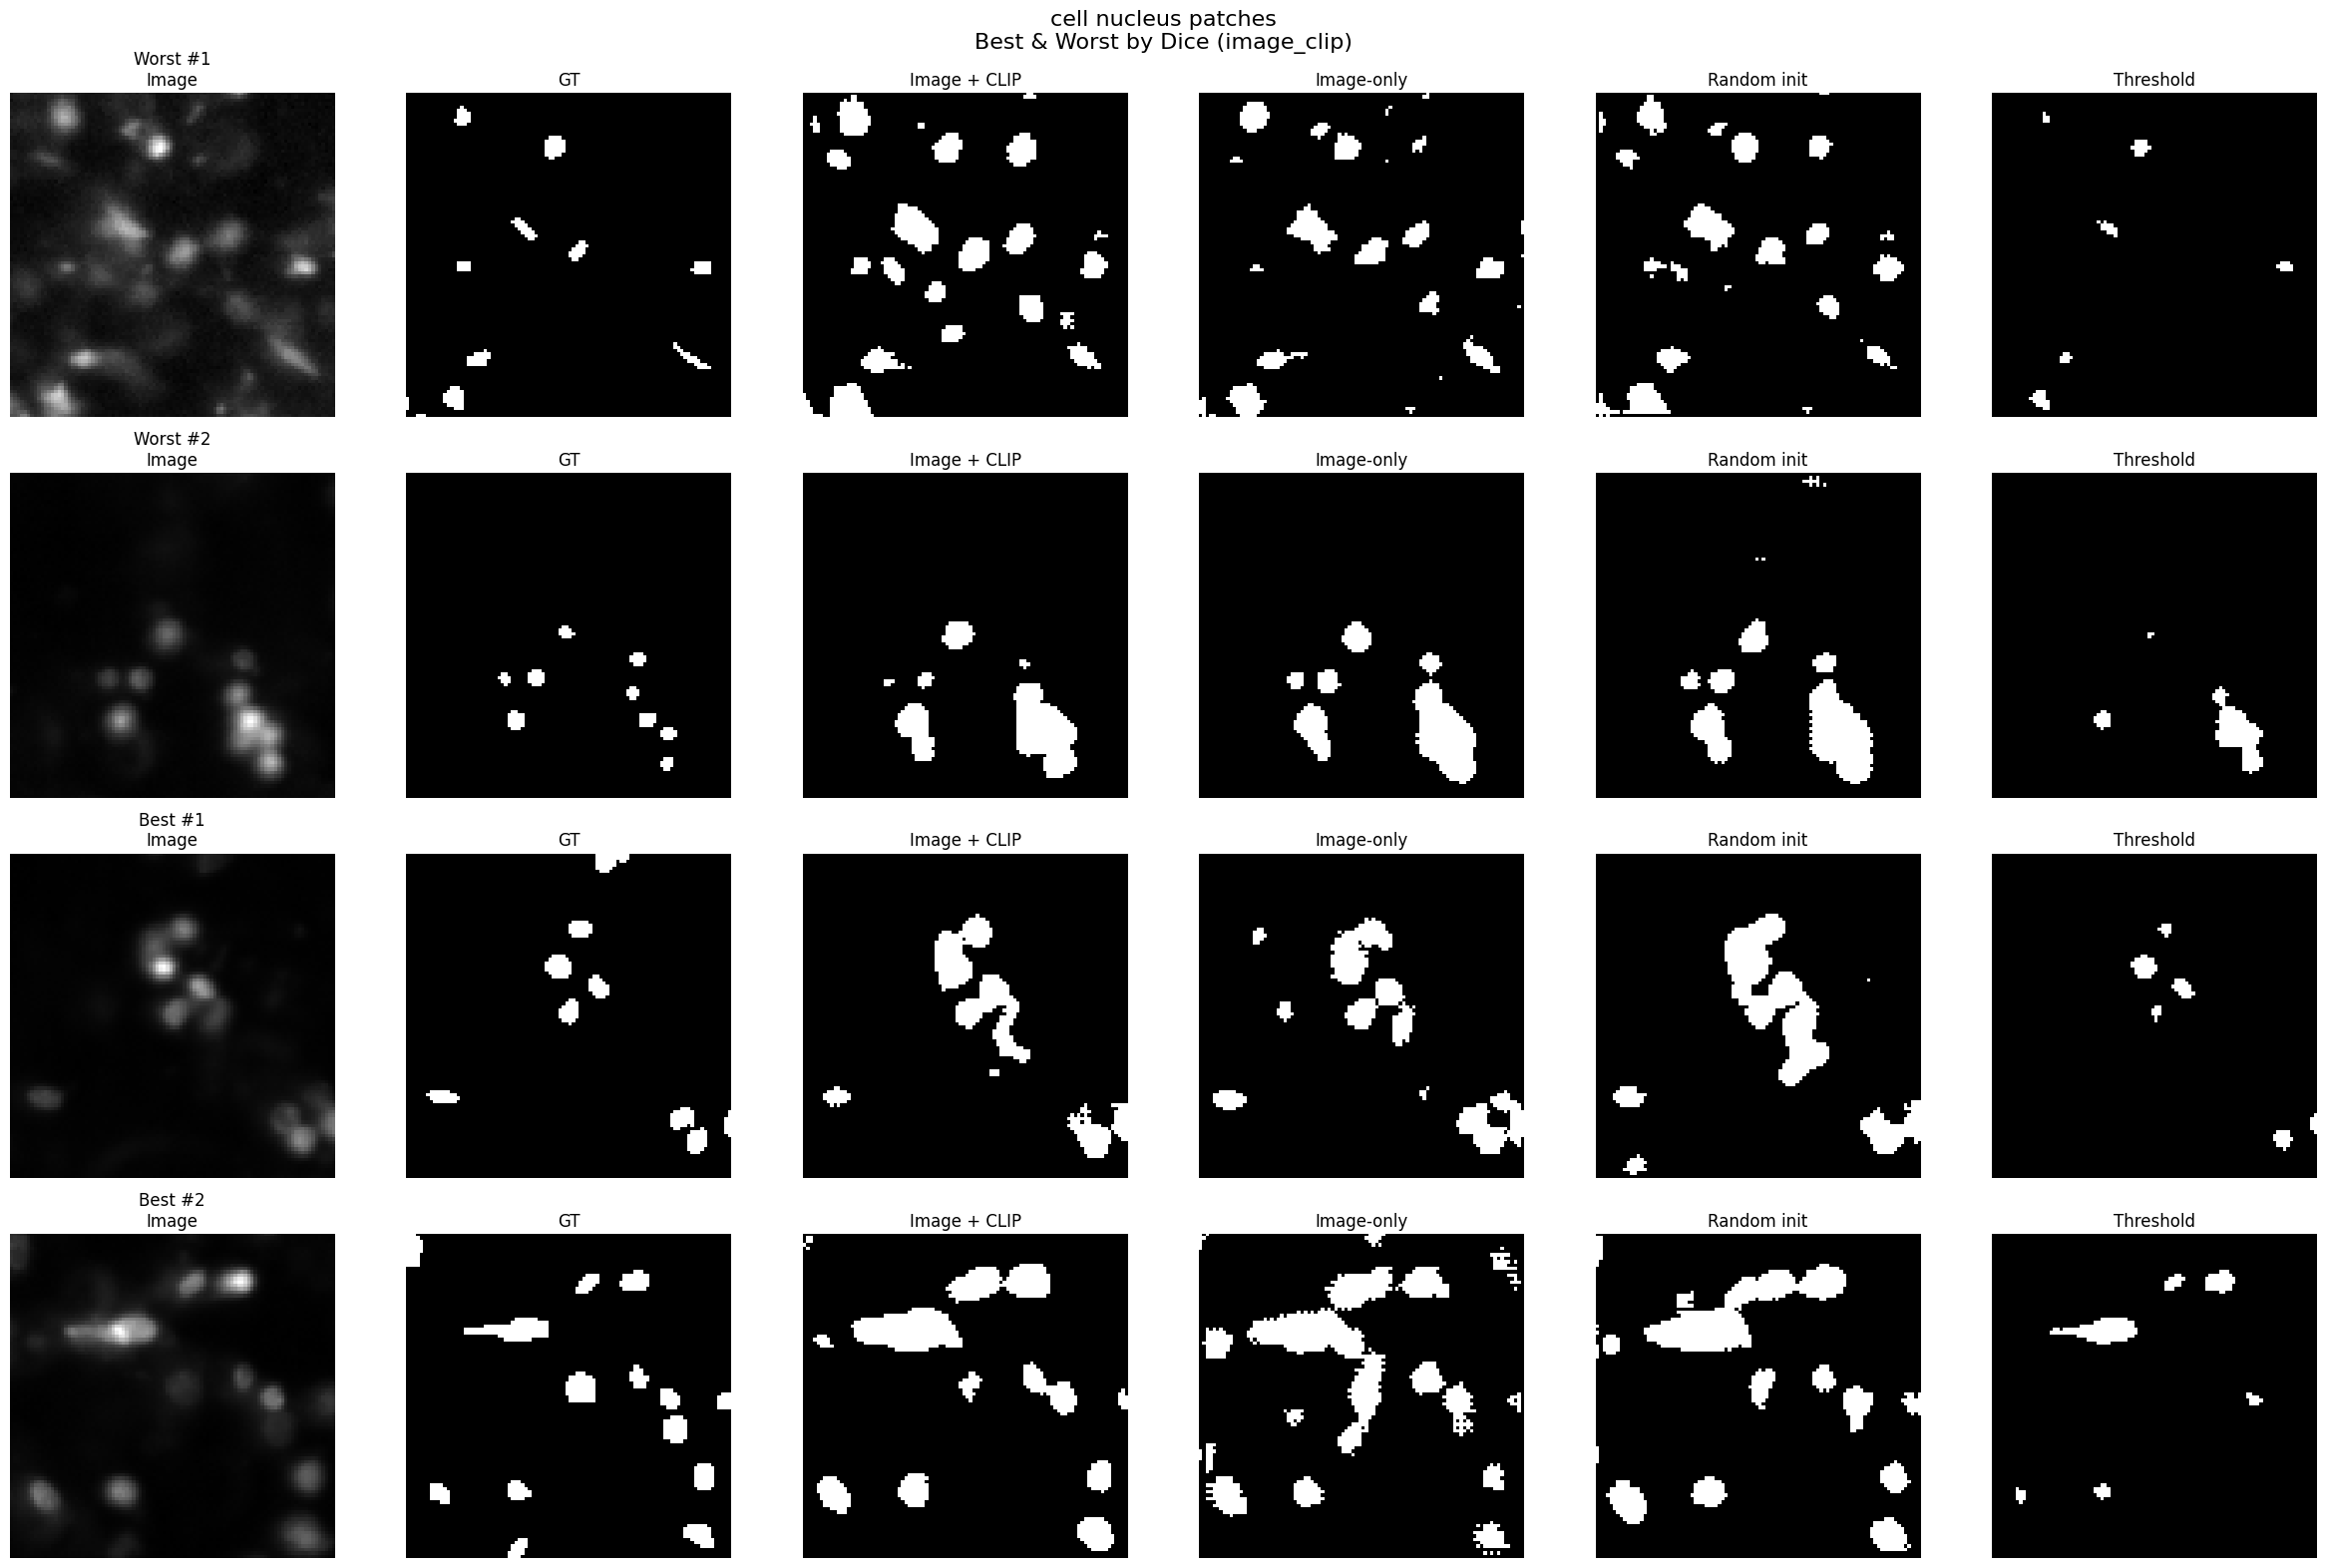

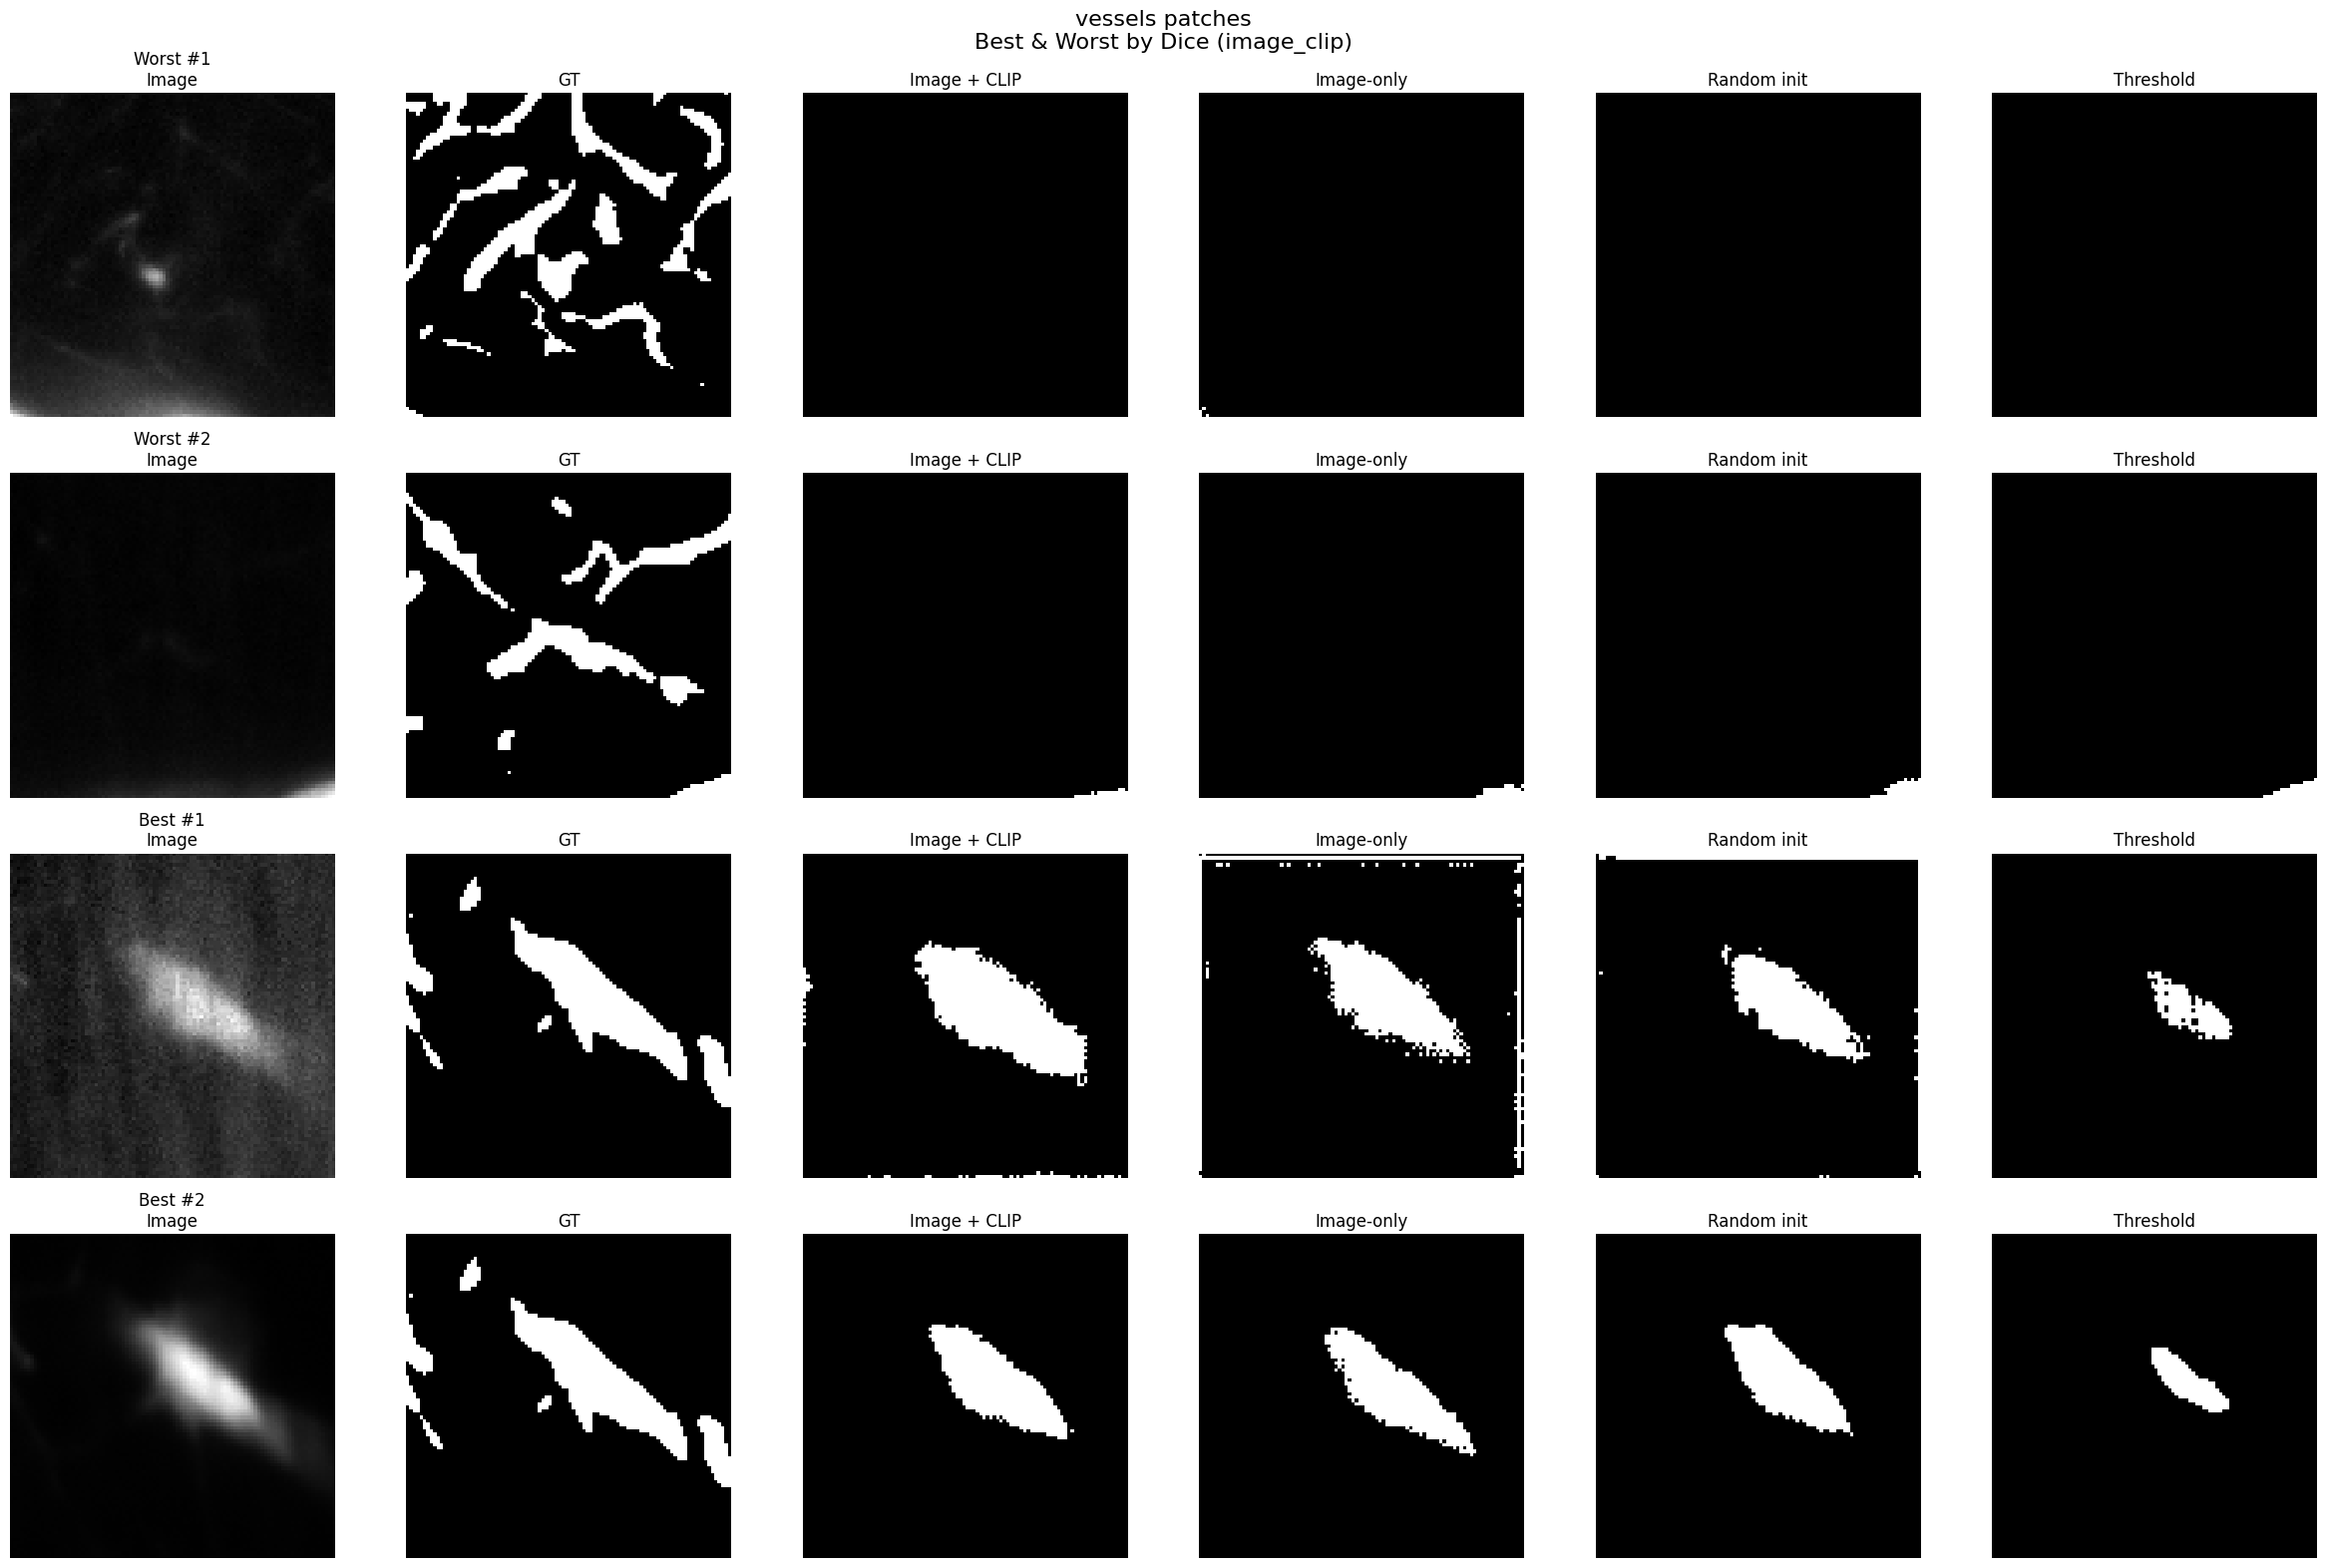

In [8]:
# visualize best/worst examples

RANK_MODEL = "image_clip"   # <<< change here if desired
N_SHOW = 2                  # best 2 + worst 2

def show_best_worst(df, dataset):
    sub = df[(df["dataset"] == dataset) & (df["model"] == RANK_MODEL)]

    # Sort patches by Dice
    sub_sorted = sub.sort_values("dice")

    worst = sub_sorted.head(N_SHOW)
    best  = sub_sorted.tail(N_SHOW)

    selected = (
        list(worst["patch"].values) +
        list(best["patch"].values)
    )

    titles = (
        [f"Worst #{i+1}" for i in range(N_SHOW)] +
        [f"Best #{i+1}" for i in range(N_SHOW)]
    )

    n_rows = len(selected)
    n_cols = 2 + len(MODELS)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(4*n_cols, 4*n_rows)
    )

    for row, (patch, title) in enumerate(zip(selected, titles)):
        img_path = os.path.join(DATA_ROOT, dataset, f"{patch}.nii.gz")
        gt_path  = os.path.join(DATA_ROOT, dataset, f"{patch}_label.nii.gz")

        img = normalize(load_nifti(img_path))
        gt  = load_nifti(gt_path)

        z = img.shape[-1] // 2

        # ---- Image ----
        axes[row, 0].imshow(img[:, :, z], cmap="gray")
        axes[row, 0].set_title(f"{title}\nImage")

        # ---- Ground truth ----
        axes[row, 1].imshow(gt[:, :, z], cmap="gray")
        axes[row, 1].set_title("GT")

        # ---- Predictions ----
        for col, model in enumerate(MODELS):
            pred_path = os.path.join(
                PRED_ROOT,
                dataset,
                f"{patch}_pred_{model}.nii.gz"
            )

            if os.path.exists(pred_path):
                pred = load_nifti(pred_path)
                axes[row, 2+col].imshow(pred[:, :, z], cmap="gray")
            else:
                axes[row, 2+col].text(
                    0.5, 0.5, "MISSING",
                    ha="center", va="center"
                )

            axes[row, 2+col].set_title(MODEL_TITLES[model])

        for a in axes[row]:
            a.axis("off")

    plt.suptitle(
        f"{dataset.replace('_', ' ')}\n"
        f"Best & Worst by Dice ({RANK_MODEL})",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run for all datasets
# -----------------------------
for dataset in DATASETS:
    show_best_worst(df, dataset)

## AUC-ROC

In [11]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt


In [12]:
def compute_patch_roc(gt, prob):
    """
    Compute ROC curve for a single patch.
    Returns fpr, tpr, auc_score.
    """
    gt_flat = gt.flatten().astype(bool)
    prob_flat = prob.flatten()

    # skip degenerate cases
    if gt_flat.sum() == 0 or gt_flat.sum() == gt_flat.size:
        return None, None, np.nan

    fpr, tpr, _ = roc_curve(gt_flat, prob_flat)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


In [13]:
def plot_roc_curves_per_dataset(
    df,
    dataset,
    data_root,
    pred_root,
    models,
    model_titles,
    n_interp=200,
):
    """
    Plot mean ROC curves per model for one dataset.
    """
    plt.figure(figsize=(6, 6))
    x_common = np.linspace(0, 1, n_interp)

    for model in models:
        fprs_interp = []
        aucs = []

        sub = df[(df["dataset"] == dataset) & (df["model"] == model)]

        for patch in sub["patch"].unique():
            gt_path = os.path.join(
                data_root, dataset, f"{patch}_label.nii.gz"
            )
            prob_path = os.path.join(
                pred_root, dataset, f"{patch}_prob_{model}.nii.gz"
            )

            if not (os.path.exists(gt_path) and os.path.exists(prob_path)):
                continue

            gt = load_nifti(gt_path)
            prob = load_nifti(prob_path)

            fpr, tpr, roc_auc = compute_patch_roc(gt, prob)
            if fpr is None:
                continue

            # interpolate to common grid
            interp_fn = interp1d(
                fpr, tpr, bounds_error=False, fill_value=(0, 1)
            )
            fprs_interp.append(interp_fn(x_common))
            aucs.append(roc_auc)

        if len(fprs_interp) == 0:
            continue

        mean_tpr = np.mean(fprs_interp, axis=0)
        std_tpr  = np.std(fprs_interp, axis=0)
        mean_auc = np.nanmean(aucs)
        std_auc  = np.nanstd(aucs)

        plt.plot(
            x_common,
            mean_tpr,
            label=f"{model_titles[model]} "
                  f"(AUC = {mean_auc:.3f} ± {std_auc:.3f})",
            linewidth=2,
        )

        plt.fill_between(
            x_common,
            mean_tpr - std_tpr,
            mean_tpr + std_tpr,
            alpha=0.2,
        )

    # chance line
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(dataset.replace("_", " "))
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


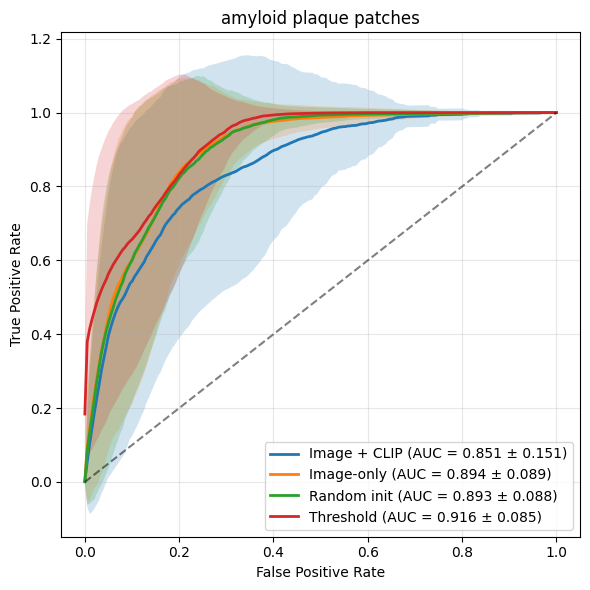

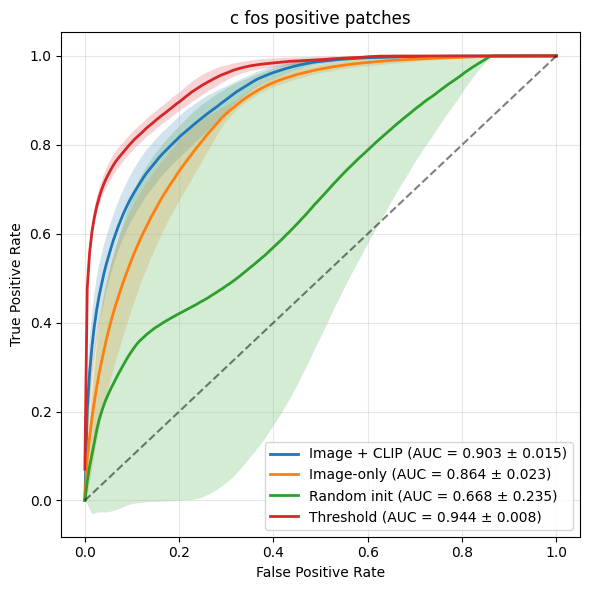

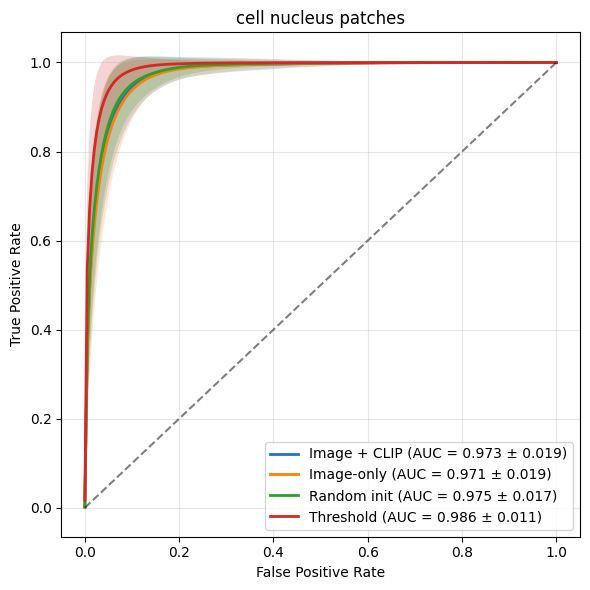

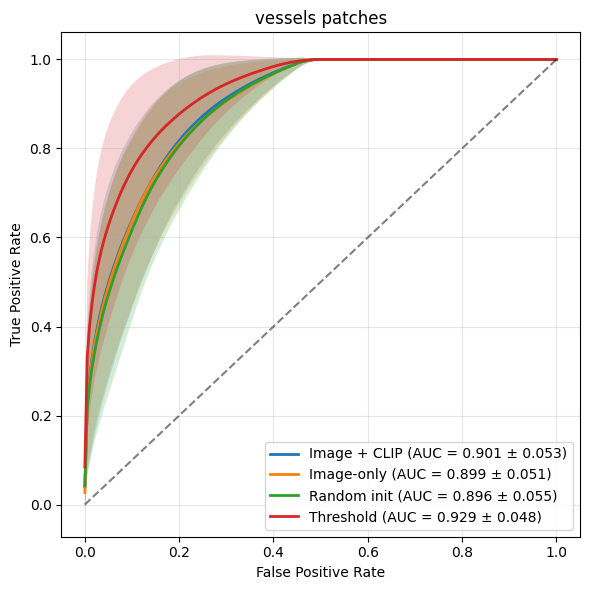

In [14]:
for dataset in DATASETS:
    plot_roc_curves_per_dataset(
        df=df,
        dataset=dataset,
        data_root=DATA_ROOT,
        pred_root=PRED_ROOT,
        models=MODELS,
        model_titles=MODEL_TITLES,
    )


## Instance Dice

In [21]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
from scipy.ndimage import label as cc_label
import seaborn as sns
import matplotlib.pyplot as plt


In [22]:
# 26-connectivity for 3D microscopy
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=np.int8)


In [23]:
def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    _, n_components = cc_label(mask, structure=structure)
    return int(n_components)


In [24]:
def label_instances(mask: np.ndarray, structure=STRUCT_3D_26):
    """
    Label connected components in a 3D binary mask.
    Returns:
        labeled_mask : int ndarray
        n_instances  : int
    """
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return np.zeros_like(mask, dtype=np.int32), 0

    labeled, n_components = cc_label(mask, structure=structure)
    return labeled.astype(np.int32), int(n_components)


In [25]:
def dice_binary(a: np.ndarray, b: np.ndarray, eps=1e-8) -> float:
    a = a.astype(bool)
    b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    return (2 * inter) / (a.sum() + b.sum() + eps)


In [26]:
def instance_dice_patch(
    gt_mask: np.ndarray,
    pred_mask: np.ndarray,
    structure=STRUCT_3D_26,
) -> float:
    """
    Mean best-match instance Dice for one 3D patch.
    """
    gt_labeled, n_gt = label_instances(gt_mask > 0, structure)

    if n_gt == 0:
        return np.nan

    pred_labeled, n_pred = label_instances(pred_mask > 0, structure)

    dice_scores = []

    for gt_id in range(1, n_gt + 1):
        gt_inst = (gt_labeled == gt_id)

        best_dice = 0.0
        for pred_id in range(1, n_pred + 1):
            pred_inst = (pred_labeled == pred_id)
            d = dice_binary(gt_inst, pred_inst)
            best_dice = max(best_dice, d)

        dice_scores.append(best_dice)

    return float(np.mean(dice_scores))


In [ ]:
# paths (same as earlier notebook)
DATA_ROOT = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
PRED_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot/results"

rows = []

for _, row in df.iterrows():
    dataset = row["dataset"]
    patch   = row["patch"]
    model   = row["model"]

    gt_path = os.path.join(DATA_ROOT, dataset, f"{patch}_label.nii.gz")
    pred_path = os.path.join(PRED_ROOT, dataset, f"{patch}_pred_{model}.nii.gz")

    if not (os.path.exists(gt_path) and os.path.exists(pred_path)):
        continue

    gt   = nib.load(gt_path).get_fdata().astype(bool)
    pred = nib.load(pred_path).get_fdata().astype(bool)

    inst_dice = instance_dice_patch(gt, pred)

    rows.append({
        "dataset": dataset,
        "patch": patch,
        "model": model,
        "instance_dice": inst_dice,
    })

df_inst = pd.DataFrame(rows)


In [ ]:
instance_summary = (
    df_inst
    .groupby(["dataset", "model"])["instance_dice"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

display(instance_summary)
